In [102]:
from src.utils.data_utils import str_dict_to_values
from src.utils.results_utils import *
from src.utils.ml_utils import *

import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px
from plotly.graph_objects import Box
from plotly.colors import qualitative as pc
import plotly.subplots as sp
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import pandas as pd
import nbformat
from IPython.display import Image
from scipy.stats import chi2_contingency
from scipy.stats import ttest_ind

# 0. Loading the cleaned dataset

In [2]:
df_char_cleaned = pd.read_csv('data/cleaned.csv')

df_char_cleaned['Languages'] = df_char_cleaned['Languages'].apply(str_dict_to_values)
df_char_cleaned['Country'] = df_char_cleaned['Country'].apply(str_dict_to_values)
df_char_cleaned['Genre_Category'] = df_char_cleaned['Genre_Category'].str.replace("'", "")

# 1. Presenting the Data
## 1.1. General 

The cleaned dataset looks like this : 

In [3]:
# Create a copy of the original DataFrame to rename columns
df_char_cleaned_column = df_char_cleaned.copy()

# Rename columns to be clearer
df_char_cleaned_column.columns = [
    'Wikipedia ID', 'Movie Name', 'Languages', 'Production Country', 'Character Name', 'Gender', 'Actor Age', 'Release Date', 'Movie Genre'
]

# Display a random sample of 5 rows from the new DataFrame
df_char_cleaned_column.sample(5)

,Wikipedia ID,Movie Name,Languages,Production Country,Character Name,Gender,Actor Age,Release Date,Movie Genre
105606,17151699,The Glory Guys,[English Language],[United States of America],Frederick,M,41.0,1965-07-07,"[Action & Adventure, Romance]"
16763,8640693,Firefly,[English Language],[United States of America],Otto,M,NaN,2005-06-11,"[Fantasy & Sci-Fi, Drama, Cult & B-Movies]"
59936,10263044,Justice Is Done,[French Language],[France],Félix,M,42.0,1950-09-20,[Drama]
115480,15886402,The Final Destination,[English Language],[United States of America],Janet,F,23.0,2009-08-26,"[Action & Adventure, Horror & Thriller]"
23240,6809438,Shree,[Tamil Language],[India],Surya,M,26.0,2002-07-19,[Action & Adventure]


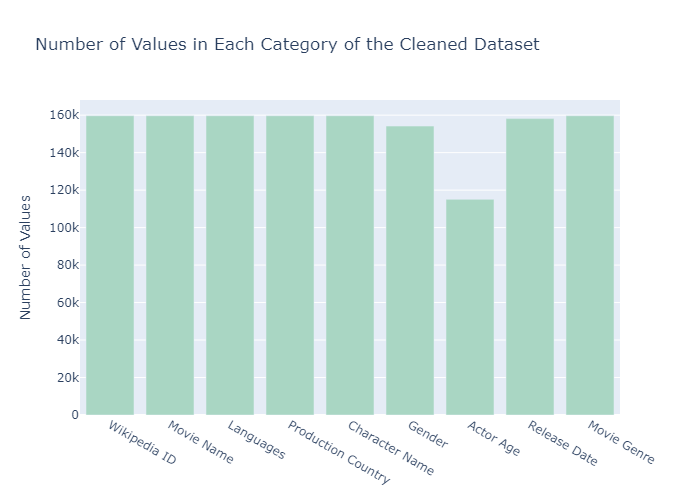

In [4]:
value_count_per_column = df_char_cleaned_column.notnull().sum()

data = go.Bar(
    x=df_char_cleaned_column.columns,
    y=value_count_per_column.values,
    marker=dict(
        color='#A9D6C3'
    ),
    text=[f"Count: {count}" for count in value_count_per_column.values],
    hoverinfo='text',
    textposition='none'
)

layout = go.Layout(
    title='Number of Values in Each Category of the Cleaned Dataset',
    yaxis=dict(title='Number of Values'),
    barmode='group'
)

fig = go.Figure(data=[data], layout=layout)

fig_path = 'images/plot_1.png'
# fig.write_image(fig_path)
Image(fig_path)

We observe that the dataset contains 160,432 entries. Some values are missing in the columns Gender, Actor Age, and Release Date.

In [5]:
total_count = len(df_char_cleaned['Character_name'])
name_count = df_char_cleaned['Character_name'].nunique()
movie_count = df_char_cleaned['Wikipedia_ID'].nunique()

summary_df = pd.DataFrame({
    'Category': ['Total Character Names','Unique Character Names', 'Unique Movies'],
    'Count': [total_count, name_count, movie_count]
})

summary_df.head()

,Category,Count
0,Total Character Names,159691
1,Unique Character Names,37883
2,Unique Movies,31072


Good diversity !

In [6]:
plot_sex_distribution_with_top_names(df_char_cleaned)

In [7]:
# Create a df with the name count per gender
df_count_gender = df_char_cleaned.groupby('Sex')['Character_name'].count()

# Create a df that show the distribution 
summary_df = pd.DataFrame({
    'Gender': df_count_gender.index,
    'Distribution (%)': df_count_gender.values/value_count_per_column['Gender']*100
})

summary_df.head()

,Gender,Distribution (%)
0,F,36.770114
1,M,63.229886


The dataset shows a slight imbalance between genders, with about half as many female entries as male. However, since there is still a substantial amount of data, this imbalance is unlikely to significantly impact the results. 

Additionally, according to a 2022 study by the Center for the Study of Women in Television and Film at San Diego State University, 34 % of leading characters in the top 100 popular films were women, compared to 66 % men. This supports the dataset's gender distribution as representative of broader industry trends.

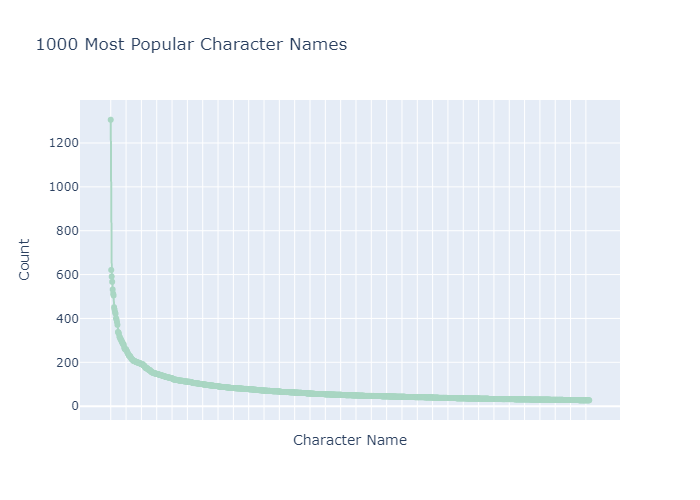

In [ ]:
# Creating the top 1000 most popular character names set
name_counts = df_char_cleaned['Character_name'].value_counts()
top_100_names = name_counts.head(1000)

fig = go.Figure()

fig.add_trace(go.Scatter(
    x=top_100_names.index,
    y=top_100_names.values,
    mode='lines+markers',
    name='Character Count',
    line=dict(color='#A9D6C3'),
    hovertext=[f"Name: {name}<br>Count: {count}" for name, count in zip(top_100_names.index, top_100_names.values)],
    hoverinfo="text",
    marker=dict(
        color='#A9D6C3'
    )
))

fig.update_layout(
    title='1000 Most Popular Character Names',
    xaxis_title='Character Name',
    yaxis_title='Count',
    xaxis=dict(showticklabels=False)
)

fig_path = 'images/plot_2.png'
# fig.write_image(fig_path)
Image(fig_path)

We can clearly see that John is the most popular name given to characters, with 1305 appartitions. One possible explanation is that John Doe was used in North America to refer to “any man whose name is unknown”. This could explain its appearance in this many movies, far ahead of the second most common name, Georges, with 621 appearances.

## 1.2. Research Questions

Names often carry meaning, cultural significance, and symbolic associations, making them an integral part of storytelling. By analyzing character names (length, vowel count, pronounciation...), we seek to determine whether they are assigned randomly or if they reflect specific traits such as the character's gender, age, the movie genre, the origin of the character, or even its moral alignment. 

Additionally, we will investigate how naming conventions differ across contexts, with a particular focus on comparing movie productions from the United States. Specifically, we aim to identify strong correlations between the portrayal of "nice guys" and "bad guys," focusing on potential differences in the depiction of Soviet characters versus American characters. This analysis aims to reveal how ideological narratives and cultural biases influenced character naming during this period.  

The first par of our research is guided by the following questions:

- Is there a correlation between a characters' name and their **gender** ?  
- Can we observe a relationship between a character's name and their **age** ?  
- How does a character's **origin** influence their name ?  
- Are character names linked to the **movie genre** they appear in ?  
- Is there a pattern in character names that distinguishes **good characters** from **villains** ?  

Then we'll build a differend models for each characteristic of the character that is linked to its name, and try to answer th following questions : 

- How do naming conventions in U.S. movie productions during the Cold War reflect ideological narratives, particularly in the portrayal of Soviet characters as "good guys" or "bad guys"?  

# 2. Identifying Patterns: Origins of the Hypothesis

A Name Feature Processor has been crated to extract all the useful information of a name.

In [11]:
# Extracting the name's characteristics 
processor = NameFeatureProcessor('Character_name',ngram_range=(2, 3))
character_names_processed = processor.process(df_char_cleaned)

Now that we have the completely processed data, we're going to see where does the idea of this work comes from.

## 2.1. Where Does the Hypothesis Come From

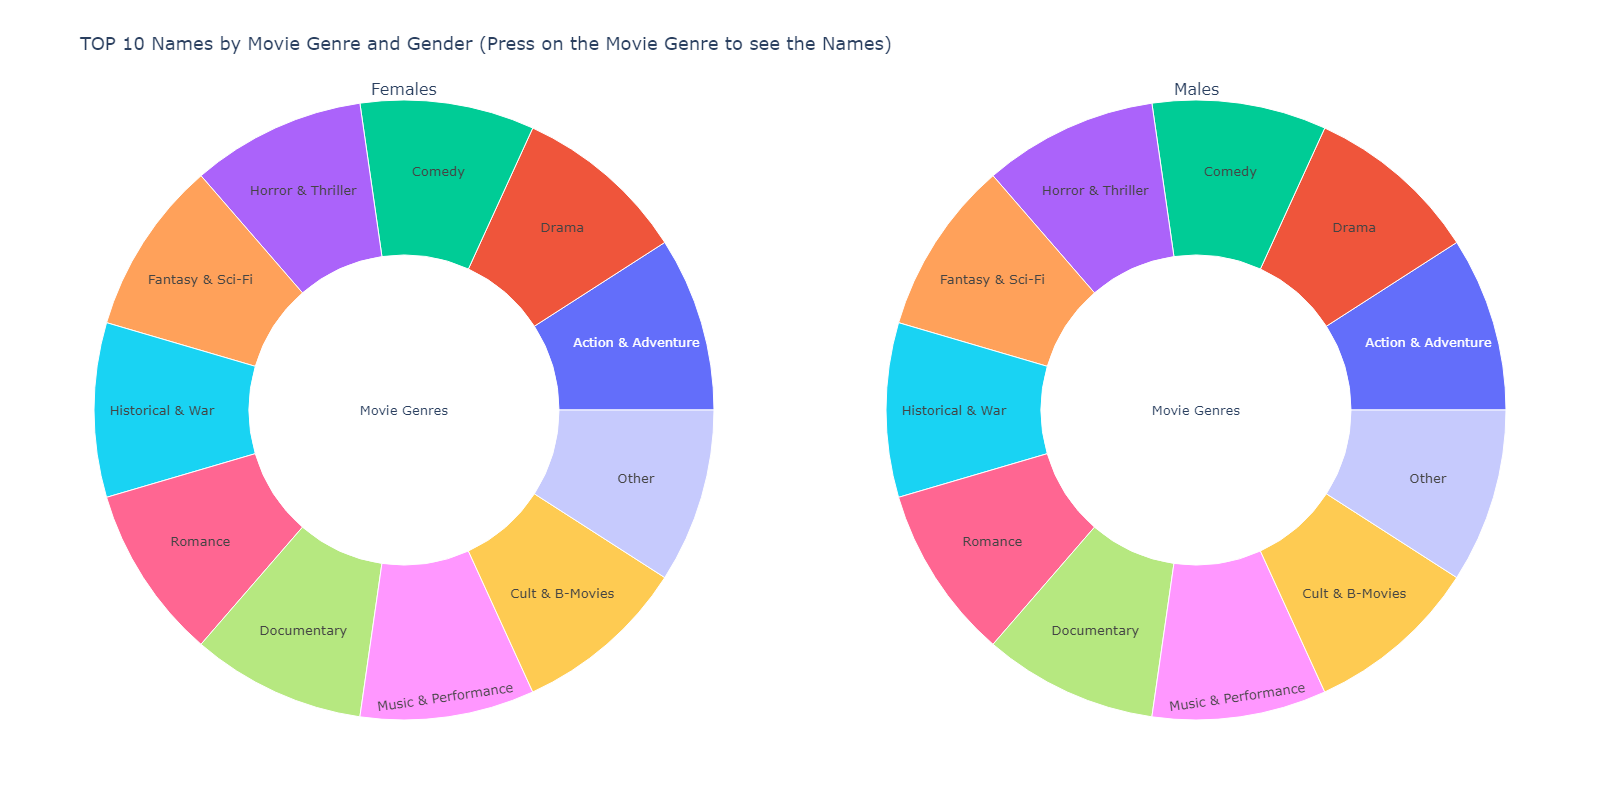

In [ ]:
analyze_genre = GenreAnalyzer(df_char_cleaned)

frequent_names_m, frequent_names_f = analyze_genre.get_top_names_by_genre(10)

data_f = analyze_genre.create_sunburst_data(frequent_names_f)
data_m = analyze_genre.create_sunburst_data(frequent_names_m)

# Create the sunburst plots for females and males
fig_females = go.Figure(go.Sunburst(
    labels=data_f['character'],
    parents=data_f['parent'],
    domain=dict(column=1),
    maxdepth=2
))

fig_males = go.Figure(go.Sunburst(
    labels=data_m['character'],
    parents=data_m['parent'],
    domain=dict(column=1),
    maxdepth=2
))

fig = make_subplots(
    rows=1, cols=2,
    subplot_titles=["Females", "Males"],
    specs=[[{"type": "sunburst"}, {"type": "sunburst"}]]
)

fig.add_trace(fig_females['data'][0], row=1, col=1)
fig.add_trace(fig_males['data'][0], row=1, col=2)

fig.update_layout(
    title_text="TOP 10 Names by Movie Genre and Gender (Press on the Movie Genre to see the Names)",
    showlegend=False,
    width=1600,
    height=800,
    font=dict(size=13),
)

fig_path = 'images/plot_3.png'
# fig.write_image(fig_path)
Image(fig_path)

The observed differences in Top 10 Names across genres provide a compelling avenue to investigate Movie Genre naming conventions. By conducting quantitative and qualitative analyses, we can uncover whether these naming patterns are coincidental or indicative of deeper correlations.

In [13]:
analyze_countries = CountryAnalyzer(df_char_cleaned)
df_continent = analyze_countries.create_continent_df()
df_continent.head()
df_top_names = analyze_countries.create_top_names_df()
analyze_countries.add_movie_count(df_top_names)
df_top_names = analyze_countries.cleaning_non_countries(df_top_names)

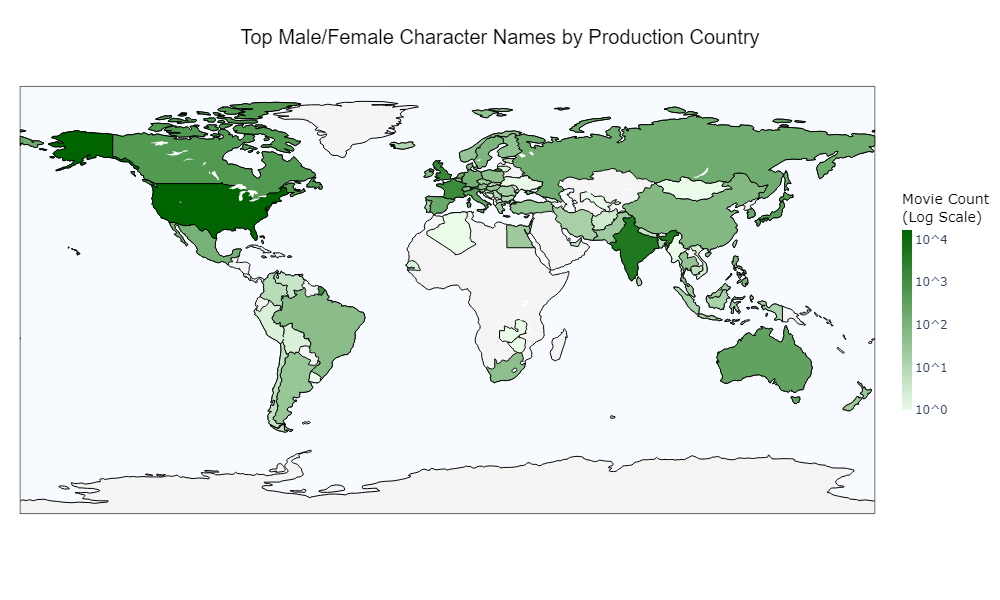

In [ ]:
fig = go.Figure()

fig.add_trace(go.Choropleth(
    locations=df_top_names['primary_country'],
    locationmode='country names',
    z=np.log10(df_top_names['Number_of_movies']),
    colorscale=[[0, '#eafbea'], [1, '#006400']],
    colorbar=dict(
        title=dict(
            text="Movie Count<br>(Log Scale)",
            font=dict(size=14, color='black')
        ),
        tickvals=np.arange(0, 5),
        ticktext=[f"10^{i}" for i in range(0, 5)],
        len=0.4,
        thickness=10,
        outlinewidth=0,
        bgcolor='white'
    ),
    marker_line_color='black',
    marker_line_width=1,
    text=[f"Top Name (F): {female}<br>Top Name (M): {male}<br>Total Movies: {movies:,}"
          for female, male, movies in zip(df_top_names['Female_name'], df_top_names['Male_name'], df_top_names['Number_of_movies'])],
    hovertemplate="<b>%{location}</b><br>%{text}<extra></extra>"
))

fig.update_geos(
    showcoastlines=True,
    coastlinecolor="black",
    showland=True,
    landcolor="whitesmoke",
    showocean=True,
    oceancolor="#F7FBFF",
    projection_type="equirectangular"
)

fig.update_layout(
    title=dict(
        text="Top Male/Female Character Names by Production Country",
        x=0.5,
        y=0.95,
        font=dict(size=20, family="Arial, bold", color="black")
    ),
    margin=dict(r=10, t=0, l=20, b=0),
    height=600,
    width=1000,
    paper_bgcolor="white",
    plot_bgcolor="white"
)
fig_path = 'images/plot_4.png'
# fig.write_image(fig_path)
Image(fig_path)

The graph highlights the diversity in character naming conventions across global movie productions. While **Sarah** and **John** dominate in U.S. productions, reflecting common American naming trends, names like **Carmen** and **Fernando** in Mexico showcase cultural influences from Spanish heritage. Similarly, other regions exhibit unique patterns tied to their linguistic and cultural contexts.

## 2.2. Finding Patterns between Name Characteristics and some Character Features from the Original Dataset

The purpose of this section is to explore whether a correlation exists between the features of characters' names and their defining characteristics. This conjecture arises from observed linguistic patterns where name structures may reflect deeper traits.

To investigate this, we analyze the following name features:

- **Length**, **Vowel Count** and **Consonant Count** 
- **First and Last Letters**  
- **Diacritics** (presence of special characters) 
- **Linguistic Consonant Groups** 
- **Sounded Encoding** (e.g., Soundex patterns)  
- **N-grams (2-3 characters)** for sequential patterns.

These attributes are examined systematically to identify potential correlations with the characters' specific features, providing a basis for further model implementation.

### 2.2.a. Name Length, Vowel Count and Consonant Count / Character Features

Firts of all, here's the analysis of Name Length, Vowel Count and Consonant Count by **Gender** :

In [15]:

character_names_processed = character_names_processed.rename(columns={'name_length': 'Length', 
                                                                      'vowel_count':'Vowel Count',
                                                                      'consonant_count':'Consonant Count'})

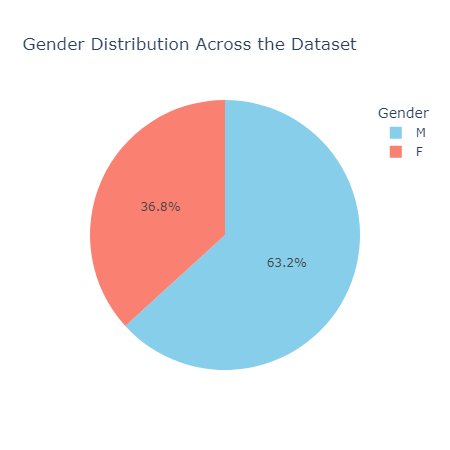

In [ ]:
data = pd.DataFrame({
    'Gender': character_names_processed['Sex'], 
    'Length': character_names_processed['Length'],
    'Vowel Count': character_names_processed['Vowel Count'],
    'Consonant Count': character_names_processed['Consonant Count']
})

# Counting occurence
gender_counts = data['Gender'].value_counts().reset_index()
gender_counts.columns = ['Gender', 'Count']  

fig = px.pie(
    gender_counts, 
    names='Gender', 
    values='Count', 
    title="Gender Distribution Across the Dataset",
    color='Gender',
    color_discrete_map={'M': '#87CEEB', 'F': '#FA8072'}  
)

fig.update_layout(
    width=450,
    height=450,
    legend_title="Gender"
)
fig_path = 'images/plot_5.png'
# fig.write_image(fig_path)
Image(fig_path)

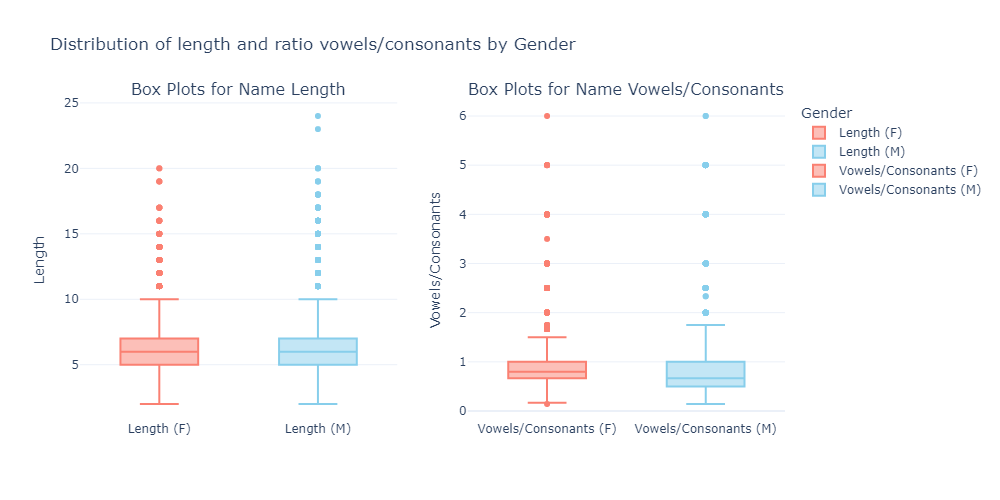

In [ ]:
data_length = pd.DataFrame({
    'Gender': character_names_processed['Sex'], 
    'Length': character_names_processed['Length']
})

data_vc = pd.DataFrame({
    'Gender': character_names_processed['Sex'], 
    'Vowels/Consonants': character_names_processed['Vowel Count'] / character_names_processed['Consonant Count']
})

data_length = data_length.dropna(subset=['Gender'])
data_vc = data_vc.dropna(subset=['Gender'])

fig = sp.make_subplots(rows=1, cols=2, subplot_titles=['Box Plots for Name Length', 'Box Plots for Name Vowels/Consonants'])

data_long_length = data_length.melt(id_vars=['Gender'], 
                                    value_vars=['Length'], 
                                    var_name='Feature', value_name='Value')
for gender in data_long_length['Gender'].unique():
    filtered_data = data_long_length[data_long_length['Gender'] == gender]
    fig.add_trace(
        Box(
            y=filtered_data['Value'],
            name=f"Length ({gender})",
            marker_color={'M': '#87CEEB', 'F': '#FA8072'}[gender]
        ),
        row=1, col=1
    )

data_long_vc = data_vc.melt(id_vars=['Gender'], 
                            value_vars=['Vowels/Consonants'], 
                            var_name='Feature', value_name='Value')
for gender in data_long_vc['Gender'].unique():
    filtered_data = data_long_vc[data_long_vc['Gender'] == gender]
    fig.add_trace(
        Box(
            y=filtered_data['Value'],
            name=f"Vowels/Consonants ({gender})",
            marker_color={'M': '#87CEEB', 'F': '#FA8072'}[gender]
        ),
        row=1, col=2
    )

fig.update_layout(
    title="Distribution of length and ratio vowels/consonants by Gender",
    width=1000,
    height=500,
    legend_title="Gender",
    template="plotly_white"
)

fig.update_xaxes(title_text="", row=1, col=1)
fig.update_yaxes(title_text="Length", row=1, col=1)
fig.update_xaxes(title_text="", row=1, col=2)
fig.update_yaxes(title_text="Vowels/Consonants", row=1, col=2)

fig_path = 'images/plot_6.png'
# fig.write_image(fig_path)
Image(fig_path)

Male names are generally longer and have more consonants, while female names are shorter with higher vowel counts, giving them a softer tone. Female names exhibit a higher median vowel count (3) compared to males (2), emphasizing their melodic quality. In contrast, male names show greater variability, with numerous outliers in length and consonant count (max = 16 for males vs. 14 for females), reflecting more complexity. This pattern may point to cultural or narrative preferences in character naming and warrants further exploration.

Now let's analyse the Name Length, Vowel Count and Consonant Count by **Age Groups** :

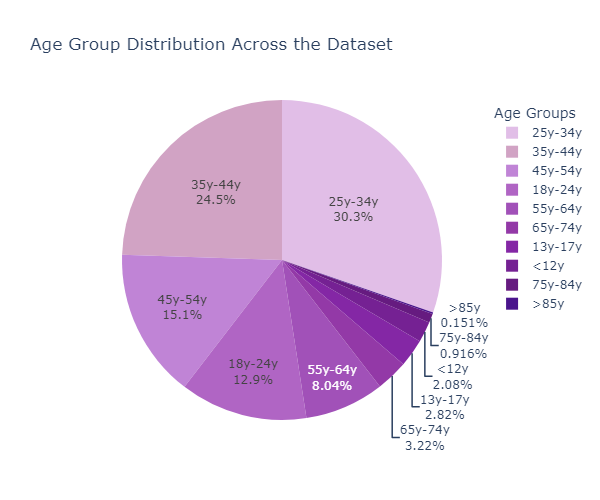

In [ ]:
data = pd.DataFrame({
    'Age Group': pd.cut(character_names_processed['Actor_age'], 
                        bins=[0, 12, 17, 24, 34, 44, 54, 64, 74, 84, 100], 
                        labels=['<12y', '13y-17y', '18y-24y', '25y-34y', '35y-44y', 
                                '45y-54y', '55y-64y', '65y-74y', '75y-84y', '>85y'], 
                        right=True),
})

purple_shades = ['#E1BEE7', '#D1A3C4', '#C084D6', '#B065C4', '#A151B8',
                 '#9339A7', '#8427A5', '#752193', '#661B80', '#4A148C']

# Calculate the distribution of age groups
age_group_distribution = data['Age Group'].value_counts().reset_index()
age_group_distribution.columns = ['Age Group', 'Count']

fig = px.pie(
    age_group_distribution, 
    names='Age Group', 
    values='Count', 
    title="Age Group Distribution Across the Dataset",
    color='Age Group',
    color_discrete_sequence=purple_shades
)

fig.update_traces(
    textinfo='percent+label',  
    hoverinfo='label+percent+value' 
)

fig.update_layout(
    legend_title="Age Groups",
    width=600,
    height=500,
)
fig_path = 'images/plot_7.png'
# fig.write_image(fig_path)
Image(fig_path)

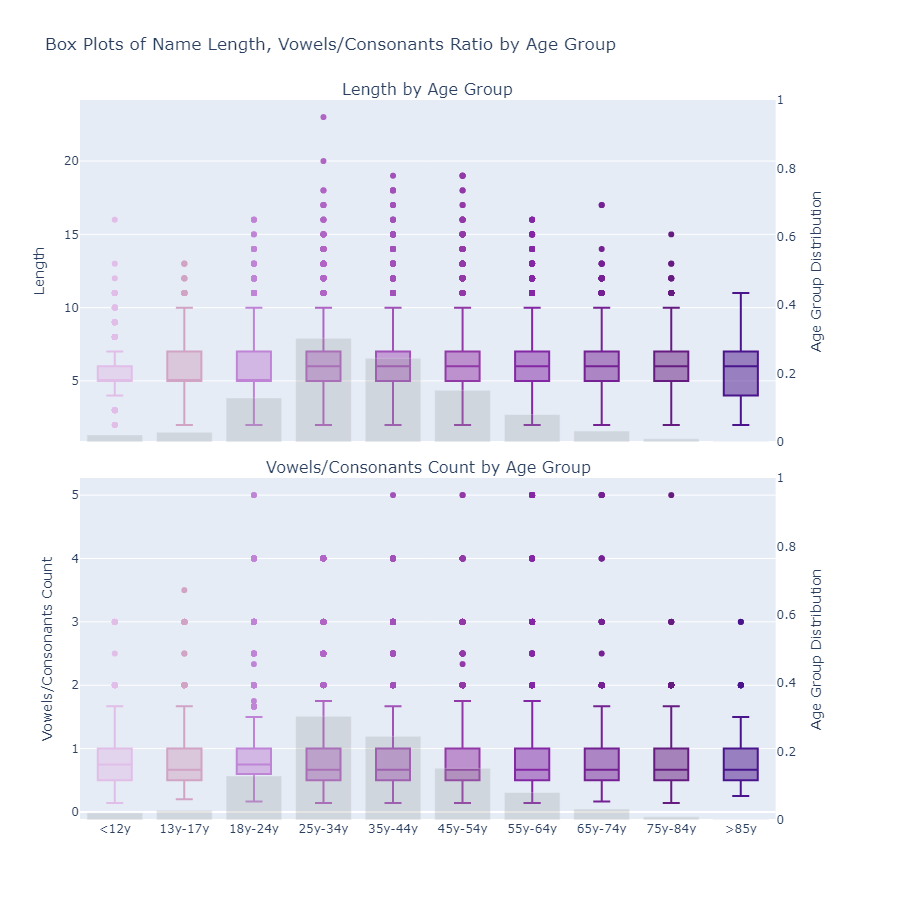

In [ ]:
data = pd.DataFrame({
    'Age Group': pd.cut(character_names_processed['Actor_age'], 
                        bins=[0, 12, 17, 24, 34, 44, 54, 64, 74, 84, 100], 
                        labels=['<12y', '13y-17y', '18y-24y', '25y-34y', '35y-44y', 
                                '45y-54y', '55y-64y', '65y-74y', '75y-84y', '>85y'], 
                        right=True),
    'Length': character_names_processed['Length'],
    'Vowels/Consonants': character_names_processed['Vowel Count']/character_names_processed['Consonant Count']
})

data['Age Group'] = pd.Categorical(data['Age Group'], 
                                   categories=['<12y', '13y-17y', '18y-24y', '25y-34y', 
                                               '35y-44y', '45y-54y', '55y-64y', 
                                               '65y-74y', '75y-84y', '>85y'], 
                                   ordered=True)

age_group_distribution = data['Age Group'].value_counts(normalize=True).reindex(data['Age Group'].cat.categories)

fig = make_subplots(
    rows=2, cols=1,
    subplot_titles=["Length by Age Group", "Vowels/Consonants Count by Age Group"],
    shared_xaxes=True,
    vertical_spacing=0.05,  
    specs=[[{"secondary_y": True}]] * 2  
)

def add_boxplot(data, feature, row, purple_shades):
    for i, age_group in enumerate(data['Age Group'].cat.categories):
        color = purple_shades[i % len(purple_shades)]
        
        # Filter data for the specific age group
        group_data = data[data['Age Group'] == age_group]
        
        fig.add_trace(
            go.Box(
                x=[age_group] * len(group_data), 
                y=group_data[feature], 
                boxpoints='outliers',  
                marker=dict(color=color), 
                line=dict(color=color), 
                name=f"{age_group} {feature}",
                showlegend=True if i == 0 else False  
            ),
            row=row, col=1, secondary_y=False
        )

# Function to add the normalized distribution
def add_normalized_distribution(distribution, row):
    fig.add_trace(
        go.Bar(
            x=distribution.index,
            y=distribution.values,
            marker=dict(color='rgba(150, 150, 150, 0.5)'),  # Light grey
            opacity=0.5,
            showlegend=False
        ),
        row=row, col=1, secondary_y=True
    )

for i, feature in enumerate(['Length', 'Vowels/Consonants']):
    add_normalized_distribution(age_group_distribution, row=i+1)
    add_boxplot(data, feature, row=i+1, purple_shades=purple_shades)

fig.update_layout(
    title_text="Box Plots of Name Length, Vowels/Consonants Ratio by Age Group",
    height=900,
    width=900,
    showlegend=False,
    xaxis=dict(tickangle=-45)
)

for i in range(1, 4):
    fig.update_yaxes(showgrid=False, secondary_y=True, row=i, col=1)
    fig.update_yaxes(title_text="Age Group Distribution", range=[0, 1], row=i, col=1, secondary_y=True)

fig.update_yaxes(title_text="Length", row=1, col=1, secondary_y=False)
fig.update_yaxes(title_text="Vowels/Consonants Count", row=2, col=1, secondary_y=False)

fig_path = 'images/plot_8.png'
# fig.write_image(fig_path)
Image(fig_path)

The dataset reveals a strong focus on characters aged **25-44 years**, who collectively represent the majority of the distribution, with **30.3%** in the 25-34 age group and **24.5%** in the 35-44 group. Younger characters (**<12 years** and **13-17 years**) and older characters (**55+ years**) are significantly underrepresented, reflecting a narrative bias towards characters in their prime adult years. 

Naming patterns align with these age group distributions, as characters in the 25-44 age range tend to have longer names with higher consonant counts, suggesting more complex naming conventions. In contrast, younger characters have shorter, simpler names with fewer consonants, which is consistent with cultural norms for child naming. Similarly, older characters exhibit simpler names, possibly reflecting traditional or familiar naming conventions. These trends underscore how age shapes character naming conventions, influenced by narrative focus and cultural preferences.

Finaly, the analysis on the Name Length, Vowel Count and Consonant Count by **Movie Genres** :

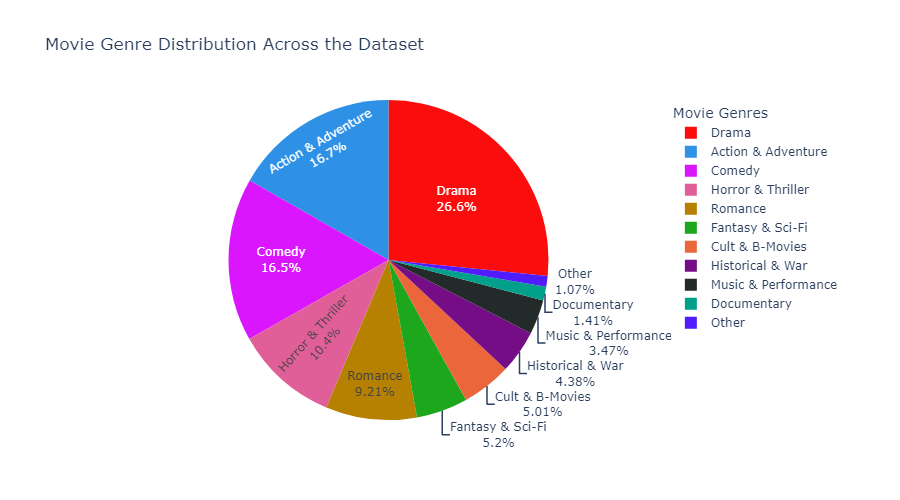

In [ ]:
analyzer = GenreAnalyzer(character_names_processed)

data = pd.DataFrame({
    'Movie Genre': character_names_processed['Genre_Category'],
    'Length': character_names_processed['Length'],
    'Vowel Count': character_names_processed['Vowel Count'],
    'Consonant Count': character_names_processed['Consonant Count']
})

# Clean and explode genres for movies with multiple genres
data['Movie Genre'] = data['Movie Genre'].astype(str).fillna('')
data['Movie Genre'] = data['Movie Genre'].str.strip("[]").str.replace("'", "").str.split(', ')
genres_exploded = data.explode('Movie Genre')

# Calculate genre distribution
genre_distribution = genres_exploded['Movie Genre'].value_counts().reset_index()
genre_distribution.columns = ['Movie Genre', 'Count']

unique_genres = genres_exploded['Movie Genre'].unique()
colors = px.colors.qualitative.Dark24
color_map = {genre: colors[i % len(colors)] for i, genre in enumerate(unique_genres)}
 
fig = px.pie(
    genre_distribution,
    names='Movie Genre',
    values='Count',  
    title="Movie Genre Distribution Across the Dataset",
    color='Movie Genre',
    color_discrete_map=color_map
)

fig.update_traces(
    textinfo='percent+label',  
    hoverinfo='label+percent+value'  
)

fig.update_layout(
    legend_title="Movie Genres",
    width=900,
    height=500,
)

fig_path = 'images/plot_9.png'
# fig.write_image(fig_path)
Image(fig_path)

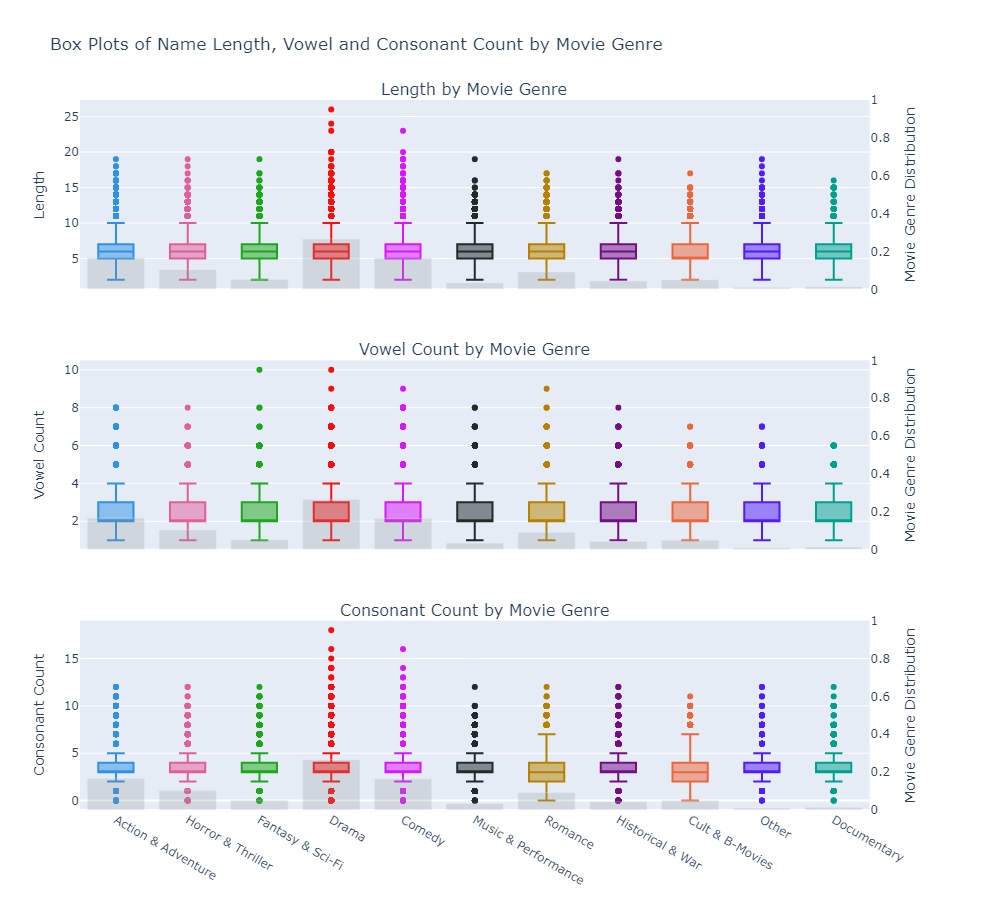

In [28]:
# Clean and explode genres for movies with multiple genres
data['Movie Genre'] = data['Movie Genre'].astype(str).fillna('')
data['Movie Genre'] = data['Movie Genre'].str.strip("[]").str.replace("'", "").str.split(', ')
genres_exploded = data.explode('Movie Genre')

# Calculate genre distribution normalized
genre_distribution = genres_exploded['Movie Genre'].value_counts(normalize=True).reset_index()
genre_distribution.columns = ['Movie Genre', 'Normalized Count']

numerical_columns = ['Length', 'Vowel Count', 'Consonant Count']

# fig with subgraphs
fig = make_subplots(
    rows=len(numerical_columns), cols=1,
    subplot_titles=[f"{col} by Movie Genre" for col in numerical_columns],
    shared_xaxes=True,
    vertical_spacing=0.1,
    specs=[[{"secondary_y": True}]] * len(numerical_columns)
)

for i, column in enumerate(numerical_columns):
    for genre in unique_genres:
        subset = genres_exploded[genres_exploded['Movie Genre'] == genre]
        fig.add_trace(
            go.Box(
                x=[genre] * len(subset),
                y=subset[column],
                name=genre ,
                boxpoints='outliers',
                marker_color=color_map[genre],
                line=dict(color=color_map[genre]),
                showlegend=(i == 0)
            ),
            row=i+1, col=1, secondary_y=False
        )

    fig.add_trace(
        go.Bar(
            x=genre_distribution['Movie Genre'],
            y=genre_distribution['Normalized Count'],
            name="Count",
            marker=dict(color='rgba(150, 150, 150, 0.5)'),
            opacity=0.5
        ),
        row=i+1, col=1, secondary_y=True
    )

fig.update_layout(
    height=900,
    width=1000,
    title_text="Box Plots of Name Length, Vowel and Consonant Count by Movie Genre",
    xaxis_tickangle=225,
    barmode='overlay',
    showlegend=False
)

for i, column in enumerate(numerical_columns):
    fig.update_yaxes(
        title_text="Movie Genre Distribution",
        range=[0, 1],
        showgrid=False,
        row=i+1, col=1, secondary_y=True
    )

fig.update_yaxes(title_text="Length", row=1, col=1, secondary_y=False)
fig.update_yaxes(title_text="Vowel Count", row=2, col=1, secondary_y=False)
fig.update_yaxes(title_text="Consonant Count", row=3, col=1, secondary_y=False)

fig_path = 'images/plot_10.png'
# fig.write_image(fig_path)
Image(fig_path)

When examining name features by movie genre, name lengths do not appear to be a decisive factor in distinguishing genres. Vowel counts are relatively consistent across genres, with medians generally falling between **2 and 4**, indicating no significant variation. Similarly, consonant counts, like name lengths, show no clear pattern that defines any specific genre. Overall, these naming features do not seem to play a determining role in characterizing movie genres.

**T-Test** on Name Length, Vowel Count and Consonant Count for each **Gender** : 

In [29]:
length_m = character_names_processed[character_names_processed['Sex'] == 'M']['Length']
length_f = character_names_processed[character_names_processed['Sex'] == 'F']['Length']

vow_m = character_names_processed[character_names_processed['Sex'] == 'M']['Vowel Count']
vow_f = character_names_processed[character_names_processed['Sex'] == 'F']['Vowel Count']

cons_m = character_names_processed[character_names_processed['Sex'] == 'M']['Consonant Count']
cons_f = character_names_processed[character_names_processed['Sex'] == 'F']['Consonant Count']

# T-Test
print("Length:")
t_stat, p_value = ttest_ind(length_m, length_f, equal_var=False)  
print(f"T-statistique : {t_stat:.4f}")
print(f"P-value : {p_value}\n")

print("Vowel Count:")
t_stat, p_value = ttest_ind(vow_m, vow_f, equal_var=False)  
print(f"T-statistique : {t_stat:.4f}")
print(f"P-value : {p_value}\n")

print("Consonant Count:")
t_stat, p_value = ttest_ind(cons_m, cons_f, equal_var=False)  
print(f"T-statistique : {t_stat:.4f}")
print(f"P-value : {p_value}")

Length:
T-statistique : -1.5946
P-value : 0.1108029382792036

Vowel Count:
T-statistique : -73.3187
P-value : 0.0

Consonant Count:
T-statistique : 46.6738
P-value : 0.0


The t-test results show **no significant difference in name length between genders** (p-value = 0.11), while there are **highly significant differences in vowel counts** (p-value = 0.0) **and consonant counts** (p-value = 0.0). This indicates that gender influences the distribution of vowels and consonants in names, but not their overall length.

### 2.2.b. Name First and Last Letter / Character Features

Now, let's explore whether the first and last letters of names play a decisive role in determining **Gender** :

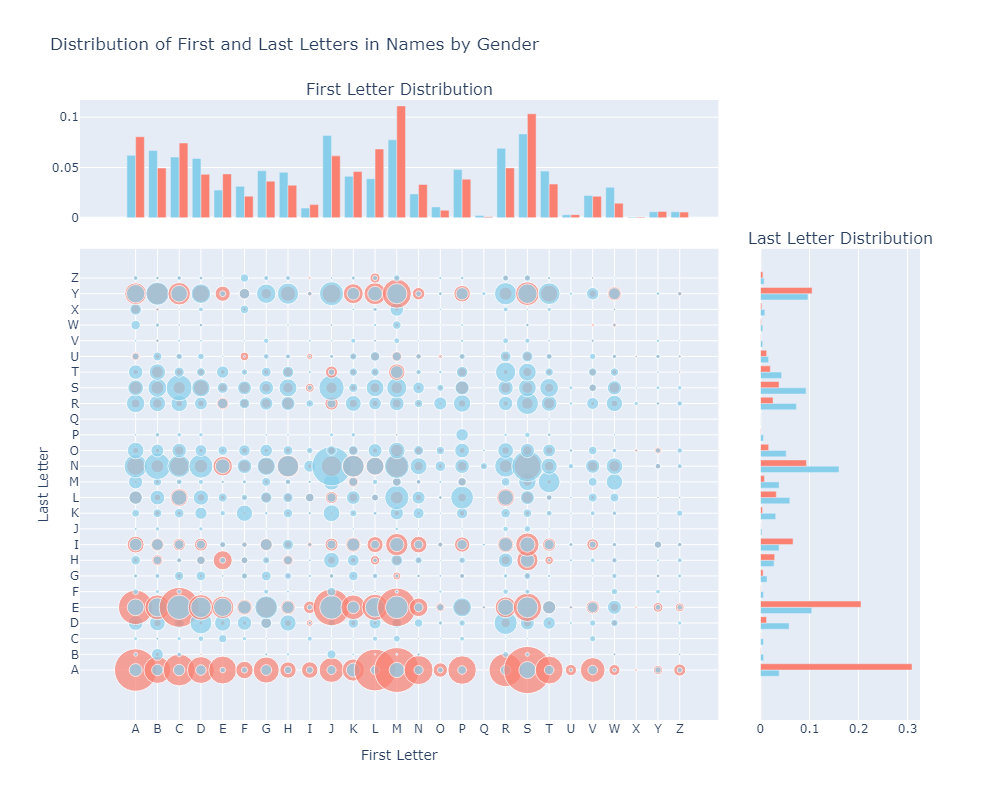

In [30]:
temp = character_names_processed.copy()

# Extract the first and last letter
temp['First_Letter'] = character_names_processed['Character_name'].str[0]
temp['Last_Letter'] = character_names_processed['Character_name'].str[-1].str.upper()

temp = temp[temp['First_Letter'].str.match(r'^[A-Z]$')]
temp = temp[temp['Last_Letter'].str.match(r'^[A-Z]$')]

gender_letters = (
    temp
    .groupby(['First_Letter', 'Last_Letter', 'Sex'])
    .size()
    .reset_index(name='Count')
)

total_count_by_gender = gender_letters.groupby('Sex')['Count'].sum().reset_index()
total_count_by_gender = total_count_by_gender.rename(columns={'Count': 'Total'})
gender_letters = gender_letters.merge(total_count_by_gender, on='Sex')
gender_letters['Distribution'] = gender_letters['Count'] / gender_letters['Total']

gender_letters_first = (
    gender_letters
    .groupby(['First_Letter', 'Sex'])['Distribution']
    .sum()
    .reset_index()
)

gender_letters_last = (
    gender_letters
    .groupby(['Last_Letter', 'Sex'])['Distribution']
    .sum()
    .reset_index()
)

alphabet_order = list('ABCDEFGHIJKLMNOPQRSTUVWXYZ')

fig = make_subplots(
    rows=2, cols=2,
    column_widths=[0.8, 0.2],
    row_heights=[0.2, 0.8],
    shared_xaxes=True,
    shared_yaxes=True,
    vertical_spacing=0.05,
    horizontal_spacing=0.05,
    subplot_titles=("First Letter Distribution", "", "", "Last Letter Distribution")
)

fig.add_trace(
    go.Scatter(
        x=gender_letters['First_Letter'],
        y=gender_letters['Last_Letter'],
        mode='markers',
        marker=dict(
            size=gender_letters['Distribution'] * 30000,  
            color=gender_letters['Sex'].map({'M': '#87CEEB', 'F': '#FA8072'}),
            opacity=0.7,
            line=dict(width=1, color="white"),
            sizemode='area',  
        ),
        customdata=gender_letters[['Distribution', 'Sex']],
        hovertemplate=(
            "First Letter: %{x}<br>"
            "Last Letter: %{y}<br>"
            "Distribution: %{customdata[0]}<br>"
            "Gender: %{customdata[1]}"
        ),
        legendgroup="Gender",
        name=""
    ),
    row=2, col=1
)

fig.update_xaxes(title_text="First Letter", row=2, col=1, categoryorder='array', categoryarray=alphabet_order)
fig.update_yaxes(title_text="Last Letter", row=2, col=1, categoryorder='array', categoryarray=alphabet_order)

# Add First Letter Distribution (top-left)
for sex, color in zip(['M', 'F'], ['#87CEEB', '#FA8072']):
    filtered_first = gender_letters_first[gender_letters_first['Sex'] == sex]
    fig.add_trace(
        go.Bar(
            x=filtered_first['First_Letter'],
            y=filtered_first['Distribution'],
            marker_color=color,
            legendgroup="Gender",  
            name=f"{sex} First Letter",
        ),
        row=1, col=1
    )

# Add Last Letter Distribution (right)
for sex, color in zip(['M', 'F'], ['#87CEEB', '#FA8072']):
    filtered_last = gender_letters_last[gender_letters_last['Sex'] == sex]
    fig.add_trace(
        go.Bar(
            x=filtered_last['Distribution'],
            y=filtered_last['Last_Letter'],
            marker_color=color,
            name=f"{sex} Last Letter",
            orientation='h',
            legendgroup="Gender",
        ),
        row=2, col=2
    )

fig.update_layout(
    title_text="Distribution of First and Last Letters in Names by Gender",
    height=800,
    width=1000,
    showlegend=False,
    barmode="group"
)

fig.update_yaxes(title_text=" ", row=1, col=1, categoryorder='array', categoryarray=alphabet_order)
fig.update_yaxes(title_text=" ", row=2, col=2, categoryorder='array', categoryarray=alphabet_order)

fig_path = 'images/plot_11.png'
# fig.write_image(fig_path)
Image(fig_path)

The graph highlights clear gender differences in the first and last letters of names. Female names tend to start with vowels like **A** and **E** and often end with **A** or **E**, giving them a softer, melodic tone. In contrast, male names show more diversity in their starting letters, favoring **J**, **D**, and **T**, and frequently end with consonants like **N**, **R**, and **S**, creating a stronger, more assertive sound. But how strong are these associations ? 

Let's perform some **Chi2-Tests** !

In [31]:
first_last_col = [col for col in character_names_processed.columns if (col.endswith('_f') or col.endswith('_l'))]

# Chi-Square tests for each column
results = {}
for col in first_last_col:
    # Create contingency table
    contingency_table = pd.crosstab(character_names_processed[col], character_names_processed['Sex'])
    chi2, p, dof, expected = chi2_contingency(contingency_table)
    
    if contingency_table.shape[0] > 1 and contingency_table.shape[1] > 1:
        n = contingency_table.sum().sum()
        min_dim = min(contingency_table.shape) - 1
        if n > 0 and min_dim > 0:
            cramers_v = np.sqrt(chi2 / (n * min_dim))
        else:
            cramers_v = np.nan
    else:
        cramers_v = np.nan

    results[col] = {'chi2': chi2, 'p_value': p, 'cramers_v': cramers_v}

significant_results = {k: v for k, v in results.items() if v['p_value'] < 0.05}

significant_results = {k: v for k, v in results.items() if v['cramers_v'] > 0.1}

print("Columns with p < 0.05 and cramers_v > 0.1 :")
for col, stats in significant_results.items():
    print(f"{col}\tChi2: {stats['chi2']:.2f}\tp-value: {stats['p_value']:.4f}\tCramér's V: {stats['cramers_v']:.4f}")

Columns with p < 0.05 and cramers_v > 0.1 :
a_l	Chi2: 22094.32	p-value: 0.0000	Cramér's V: 0.3785
d_l	Chi2: 1897.47	p-value: 0.0000	Cramér's V: 0.1109
e_l	Chi2: 2980.42	p-value: 0.0000	Cramér's V: 0.1390
s_l	Chi2: 1598.32	p-value: 0.0000	Cramér's V: 0.1018


The results of the **Chi-squared test** show that certain letters (such as `a_l`, `d_l`, `e_l`, and `s_l`) have a **strong and significant** relationship with **gender** (male or female), with **p-values of 0.0**. The **Cramér's V** for these columns is around **0.3**, indicating a **moderate to small (but existing !) association** between the letters and gender. In the visualizations, the **distributions of first and last letters** show that certain letters (like **A** and **B**) are much more common in female names, while others (like **J** and **K**) dominate in male names. These results suggest that first and last letters of names have a **significant impact** on gender differentiation.

Now we'll look at this for **Movie Genres** : 

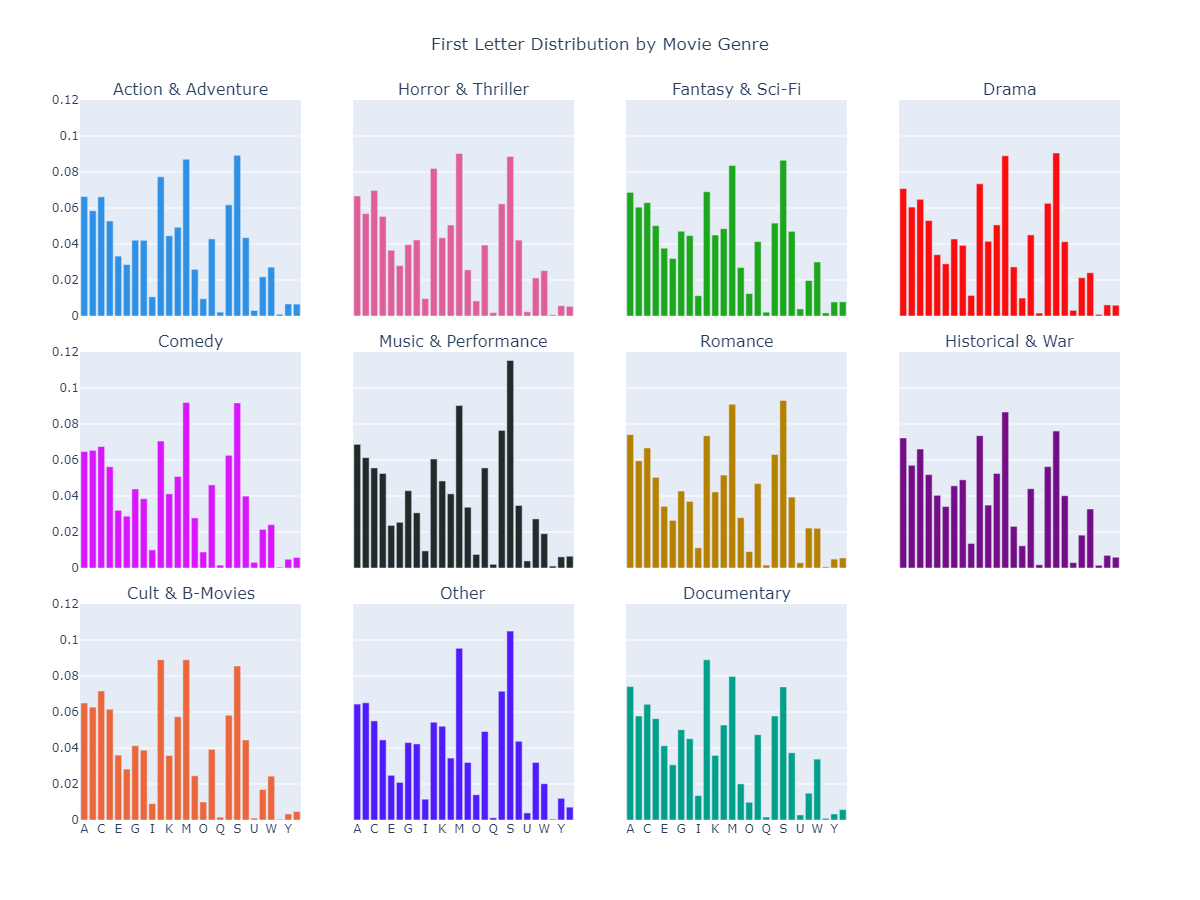

In [ ]:
colors = px.colors.qualitative.Dark24

movie_genres = [
    'Action & Adventure', 
    'Horror & Thriller', 
    'Fantasy & Sci-Fi', 
    'Drama', 
    'Comedy', 
    'Music & Performance', 
    'Romance', 
    'Historical & War', 
    'Cult & B-Movies', 
    'Other', 
    'Documentary'
]

temp = character_names_processed.copy()

# Extract first and last letters
temp['First_Letter'] = character_names_processed['Character_name'].str[0]
temp['Last_Letter'] = character_names_processed['Character_name'].str[-1].str.upper()

# Keep only alphabetic letters
temp = temp[temp['First_Letter'].str.match(r'^[A-Z]$')]
temp = temp[temp['Last_Letter'].str.match(r'^[A-Z]$')]

# Clean genre data and explode multiple genres
temp['Genre_Category'] = temp['Genre_Category'].astype(str).fillna('')
temp['Genre_Category'] = temp['Genre_Category'].str.strip("[]").str.replace("'", "").str.split(', ')
genres_exploded = temp.explode('Genre_Category')

genre_letters = (
    genres_exploded
    .groupby(['First_Letter', 'Genre_Category'])
    .size()
    .reset_index(name='Count')
)

# Calculate distribution for each genre
total_count_by_genre = genre_letters.groupby('Genre_Category')['Count'].sum().reset_index()
total_count_by_genre = total_count_by_genre.rename(columns={'Count': 'Total'})
genre_letters = genre_letters.merge(total_count_by_genre, on='Genre_Category')
genre_letters['Distribution'] = genre_letters['Count'] / genre_letters['Total']

fig = make_subplots(
    rows=3, cols=4,
    column_widths=[0.2] * 4,  
    row_heights=[0.3] * 3,    
    shared_xaxes=True,
    shared_yaxes=True,
    vertical_spacing=0.05,
    horizontal_spacing=0.05,
    subplot_titles=movie_genres  
)

row = 1
col = 1

for i, genre in enumerate(movie_genres):
    color = colors[i % len(colors)]  
    filtered_data = genre_letters[genre_letters['Genre_Category'] == genre]
    
    fig.add_trace(
        go.Bar(
            x=filtered_data['First_Letter'],
            y=filtered_data['Distribution'],
            name=genre,  
            marker_color=color,
            hovertemplate=(
                "First Letter: %{x}<br>"  
                "Distribution: %{y:.4f}<br>" 
            ),
        ),
        row=row, col=col
    )
    
    col += 1
    if col > 4:
        col = 1
        row += 1

fig.update_yaxes(range=[0, 0.12])

fig.update_layout(
    title="First Letter Distribution by Movie Genre",
    height=900,
    width=1200,
    showlegend=False,
    barmode="group",
    title_x=0.5
)
fig_path = 'images/plot_12.png'
# fig.write_image(fig_path)
Image(fig_path)

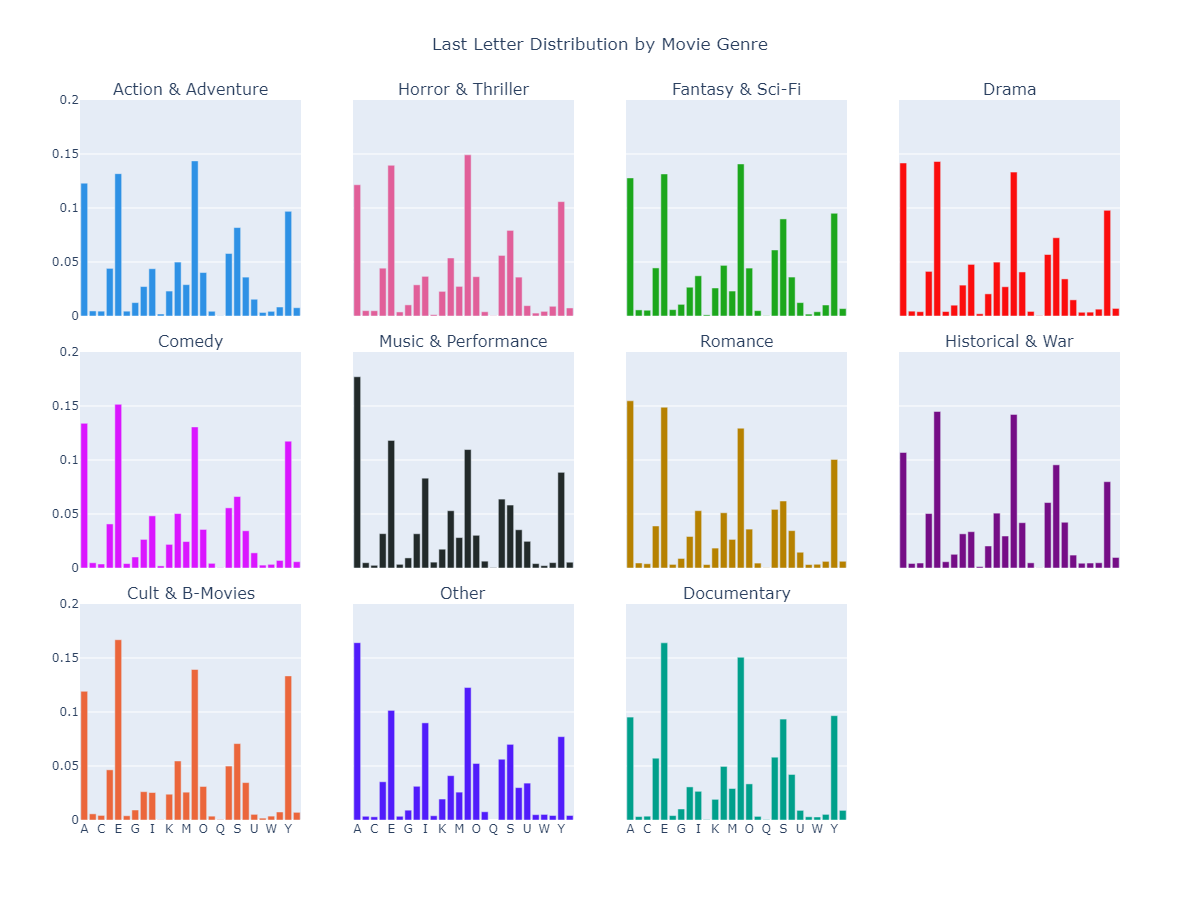

In [ ]:
colors = px.colors.qualitative.Dark24

temp = character_names_processed.copy()

temp['First_Letter'] = character_names_processed['Character_name'].str[0]
temp['Last_Letter'] = character_names_processed['Character_name'].str[-1].str.upper()

temp = temp[temp['First_Letter'].str.match(r'^[A-Z]$')]
temp = temp[temp['Last_Letter'].str.match(r'^[A-Z]$')]

# Clean genre data and explode multiple genres
temp['Genre_Category'] = temp['Genre_Category'].astype(str).fillna('')
temp['Genre_Category'] = temp['Genre_Category'].str.strip("[]").str.replace("'", "").str.split(', ')
genres_exploded = temp.explode('Genre_Category')

# Group data to calculate distributions
genre_letters = (
    genres_exploded
    .groupby(['Last_Letter', 'Genre_Category'])
    .size()
    .reset_index(name='Count')
)

# Calculate distribution for each genre
total_count_by_genre = genre_letters.groupby('Genre_Category')['Count'].sum().reset_index()
total_count_by_genre = total_count_by_genre.rename(columns={'Count': 'Total'})
genre_letters = genre_letters.merge(total_count_by_genre, on='Genre_Category')
genre_letters['Distribution'] = genre_letters['Count'] / genre_letters['Total']

fig = make_subplots(
    rows=3, cols=4,
    column_widths=[0.2] * 4,  
    row_heights=[0.3] * 3,    
    shared_xaxes=True,
    shared_yaxes=True,
    vertical_spacing=0.05,
    horizontal_spacing=0.05,
    subplot_titles=movie_genres
)

row = 1
col = 1

for i, genre in enumerate(movie_genres):
    color = colors[i % len(colors)]  
    filtered_data = genre_letters[genre_letters['Genre_Category'] == genre]
    
    fig.add_trace(
        go.Bar(
            x=filtered_data['Last_Letter'],
            y=filtered_data['Distribution'],
            name=genre,  
            marker_color=color,
            hovertemplate=(
                "Last Letter: %{x}<br>"  
                "Distribution: %{y:.4f}<br>"  
            ),
        ),
        row=row, col=col
    )
    
    col += 1
    if col > 4:
        col = 1
        row += 1

fig.update_yaxes(range=[0, 0.2])

fig.update_layout(
    title="Last Letter Distribution by Movie Genre",
    height=900,
    width=1200,
    showlegend=False,
    barmode="group",
    title_x=0.5
)

fig_path = 'images/plot_13.png'
# fig.write_image(fig_path)
Image(fig_path)

The analysis of first and last letter distributions by Movie Genre does not appear to yield conclusive patterns. While certain letters may show slightly higher frequencies in specific genres, there is no consistent trend or decisive correlation between the choice of first or last letters and the Movie Genre. 

We'll try **Chi-Square testing on these** :

In [37]:
first_last_col = [col for col in character_names_processed.columns if (col.endswith('_f') or col.endswith('_l'))]

# Chi-Square tests for each column
results = {}
for col in first_last_col:
    # Create contingency table
    contingency_table = pd.crosstab(genres_exploded[col], genres_exploded['Genre_Category'])
    chi2, p, dof, expected = chi2_contingency(contingency_table)
    
    if contingency_table.shape[0] > 1 and contingency_table.shape[1] > 1:
        n = contingency_table.sum().sum()
        min_dim = min(contingency_table.shape) - 1
        if n > 0 and min_dim > 0:
            cramers_v = np.sqrt(chi2 / (n * min_dim))
        else:
            cramers_v = np.nan
    else:
        cramers_v = np.nan

    results[col] = {'chi2': chi2, 'p_value': p, 'cramers_v': cramers_v}

significant_results = {k: v for k, v in results.items() if v['p_value'] < 0.05}

significant_results = {k: v for k, v in results.items() if v['cramers_v'] > 0.05}

print("Columns with p < 0.05 and cramers_v > 0.05 :")
for col, stats in significant_results.items():
    print(f"{col}\tChi2: {stats['chi2']:.2f}\tp-value: {stats['p_value']:.4f}\tCramér's V: {stats['cramers_v']:.4f}")

Columns with p < 0.05 and cramers_v > 0.05 :
i_l	Chi2: 1068.62	p-value: 0.0000	Cramér's V: 0.0529


The Chi-Square test indicates a slight relationship between "i" as a last letter and Movie Genre classification (**p-value = 0.000**, **Chi2 = 1068.62**), but Cramér's V = 0.0529 is below the significance threshold of 0.1, suggesting minimal practical influence on Movie Genre classification.

### 2.2.c. Name Diacritics / Character Features

Let’s now examine the influence of special characters in character naming, focusing first on their potential effect on **Gender** differentiation :

In [38]:
# Specified string of diacritics
diacritics_str = "üéèäöÃëçÖïáéäÔþçÁøõãæšáàÂùðìôêÖØÀûßýÉïåÓúśíłÅÞūžâÍÈëōîñüèóöÕò"

# Extract diacritic characters
diacritics_set = set(diacritics_str)

# Select columns corresponding to diacritics
selected_columns = [col for col in character_names_processed.columns if col in diacritics_set]

results = {}
for diacritic in selected_columns:
    # Chi-Square test 
    contingency_table = pd.crosstab(character_names_processed[diacritic], character_names_processed['Sex'])
    chi2, p, dof, expected = chi2_contingency(contingency_table)  
    
    # Calculate Cramér's V
    n = contingency_table.sum().sum()  
    min_dim = min(contingency_table.shape) - 1  
    cramers_v = np.sqrt(chi2 / (n * min_dim))  
    
    results[diacritic] = {'chi2': chi2, 'p_value': p, 'cramers_v': cramers_v}

# Display significant results (p-value < 0.05)
significant_results = {k: v for k, v in results.items() if v['p_value'] < 0.05}
print("\nDiacritics with a significant association with gender (p-value < 0.05):")
for diacritic, stats in significant_results.items():
    print(f"Diacritic: {diacritic}, Chi2: {stats['chi2']:.2f}, p-value: {stats['p_value']:.4f}, Cramér's V: {stats['cramers_v']:.4f}")


Diacritics with a significant association with gender (p-value < 0.05):
Diacritic: á, Chi2: 4.24, p-value: 0.0394, Cramér's V: 0.0052
Diacritic: ø, Chi2: 12.66, p-value: 0.0004, Cramér's V: 0.0091
Diacritic: ã, Chi2: 9.62, p-value: 0.0019, Cramér's V: 0.0079
Diacritic: ú, Chi2: 6.64, p-value: 0.0100, Cramér's V: 0.0066
Diacritic: é, Chi2: 24.60, p-value: 0.0000, Cramér's V: 0.0126
Diacritic: î, Chi2: 8.25, p-value: 0.0041, Cramér's V: 0.0073
Diacritic: ó, Chi2: 6.56, p-value: 0.0104, Cramér's V: 0.0065
Diacritic: è, Chi2: 59.73, p-value: 0.0000, Cramér's V: 0.0197
Diacritic: ë, Chi2: 9.28, p-value: 0.0023, Cramér's V: 0.0078
Diacritic: ñ, Chi2: 10.39, p-value: 0.0013, Cramér's V: 0.0082
Diacritic: ô, Chi2: 21.29, p-value: 0.0000, Cramér's V: 0.0118


No Cramér's V > 0.1 so none of them is significant.

Let's look if it has an impact on the **Age Category** of the Character :

In [39]:
selected_columns = [col for col in character_names_processed.columns if col in diacritics_set]

results = {}

for diacritic in selected_columns:
    # T-test
    t_stat, p_value = ttest_ind(character_names_processed['Actor_age'], character_names_processed[diacritic], equal_var=False) 
    results[diacritic] = {'t-statistic': t_stat, 'p-value': p_value}

# Filter significant results (p-value < 0.05)
significant_results = {k: v for k, v in results.items() if v['p-value'] < 0.05}

print("\nDiacritics with a significant association with Actor_age (p-value < 0.05):")
for diacritic, stats in significant_results.items():
    print(f"Diacritic: {diacritic}, t-statistic: {stats['t-statistic']:.2f}, p-value: {stats['p-value']:.4f}")


Diacritics with a significant association with Actor_age (p-value < 0.05):


Looks like it doesn't have any effect... maybe **Movie Genres** :

In [40]:
temp = character_names_processed.explode('Genre_Category')

# Select columns corresponding to diacritics
selected_columns = [col for col in temp.columns if col in diacritics_set]

results = {}
for diacritic in selected_columns:
    # Chi-Square test 
    contingency_table = pd.crosstab(temp[diacritic], temp['Genre_Category'])
    chi2, p, dof, expected = chi2_contingency(contingency_table)  
    
    # Calculate Cramér's V
    n = contingency_table.sum().sum()  
    min_dim = min(contingency_table.shape) - 1  
    cramers_v = np.sqrt(chi2 / (n * min_dim))  
    
    results[diacritic] = {'chi2': chi2, 'p_value': p, 'cramers_v': cramers_v}

# Display significant results (p-value < 0.05)
significant_results = {k: v for k, v in results.items() if v['p_value'] < 0.05}
print("\nDiacritics with a significant association with Movie Genre (p-value < 0.05):")
for diacritic, stats in significant_results.items():
    print(f"Diacritic: {diacritic}, Chi2: {stats['chi2']:.2f}, p-value: {stats['p_value']:.4f}, Cramér's V: {stats['cramers_v']:.4f}")


Diacritics with a significant association with Movie Genre (p-value < 0.05):
Diacritic: á, Chi2: 1755.61, p-value: 0.0000, Cramér's V: 0.1049
Diacritic: š, Chi2: 26621.80, p-value: 0.0000, Cramér's V: 0.4083
Diacritic: é, Chi2: 1422.33, p-value: 0.0028, Cramér's V: 0.0944
Diacritic: î, Chi2: 3395.41, p-value: 0.0000, Cramér's V: 0.1458
Diacritic: ï, Chi2: 1480.67, p-value: 0.0001, Cramér's V: 0.0963
Diacritic: ö, Chi2: 2244.18, p-value: 0.0000, Cramér's V: 0.1185
Diacritic: ü, Chi2: 1630.19, p-value: 0.0000, Cramér's V: 0.1010
Diacritic: ê, Chi2: 1597.28, p-value: 0.0000, Cramér's V: 0.1000
Diacritic: ž, Chi2: 31937.40, p-value: 0.0000, Cramér's V: 0.4472
Diacritic: ô, Chi2: 1729.98, p-value: 0.0000, Cramér's V: 0.1041


No Cramér's V > 0.1 so even if the p-values are > 0.5, we can't denote a significant association.

### 2.2.d. Consonant Groups / Character Features

In Phonetics (the study of sound patterns occuring in language), consonant sounds are divided according to different rules. They can be divided in two way:
- **Place of articulation**, where the focus is on which parts of the mouth produce the sounds,
- **Manner of articulation**, where the focus is on how the flow of air is obstructed during the production of the sound. 

We will focus on the latter for our analysis. This liguistic framework, gives us the opportunity to do a deeper analysis on relationship between character features and consonants.

**List of 6 "Last" Names by Manner of Articulation:**

| **Manner**        | **Description**                                                                                                                                       | **Examples**       |
|--------------------|-------------------------------------------------------------------------------------------------------------------------------------------------------|--------------------|
| **Plosive (Stop)** | 1. By completely obstructing airstream<br>2. Building up air pressure<br>3. Then releasing it.                                                        | /p/ /b/ /t/ /d/ /k/ /g/ |
| **Fricative**      | 1. By forcing the breath through a constriction formed by articulators in the vocal tract.                                                           | /f/ /v/ /θ/ /ð/ /s/ /z/ /ʃ/ /ʒ/ /h/ |
| **Affricate**      | 1. By having both a fricative and plosive way of producing sound.                                                                                     | /tʃ/ /dʒ/          |
| **Nasal**          | 1. By completely closing the oral cavity along with lowering the velum to allow airflow through the nasal cavity.                                     | /m/ /n/ /ŋ/        |
| **Liquid**         | 1. When airstream proceeds along the sides of the tongue but is blocked by the tongue from going through the middle of the mouth. <br> /r/ and /l/.   | /r/ /l/            |
| **Glide**          | 1. By having a continuous and gliding motion of the articulators into the following vowel... sometimes considered a semi-vowel.                       | /j/ /w/            |

> **Note**: 
> - *Some are too specialized, so I did not list them here.*
> - **Both liquids and glides are sometimes called "approximates."**


In [41]:
# We will divide consonants by their manner of articulation
plosive = ['P','T','B','K']
fricative = ['F','X','0','S','H']
affricate = ['J']
nasal =['M','N']
liquid = ['L','R']
manner_groups = [plosive,fricative,affricate,nasal,liquid]
manner_names = ['plosive','fricative','affricate','nasal','liquid']

In [42]:
analyze_phonetics = PhoneticAnalyzer(df_char_cleaned,manner_groups,manner_names)

In [43]:
manner_df = analyze_phonetics.phonetics_by_gender()

d:\ada-2024-project-adadasurmonbidet2024\src\utils\results_utils.py:529: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`



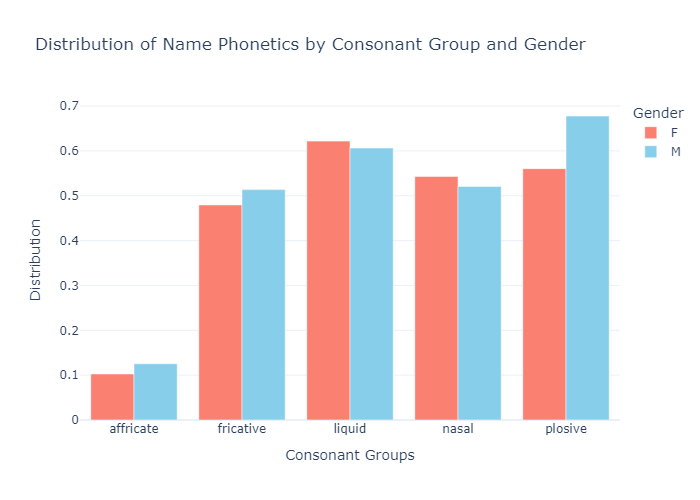

In [47]:
fig = go.Figure()

sexes = manner_df['Sex'].unique()

color_map ={
    'M':'#87CEEB', 
    'F':'#FA8072'
}
for sex in sexes:
    filtered_df = manner_df[manner_df['Sex'] == sex]
    fig.add_trace(go.Bar(
        x=filtered_df['Consonant_Group'],
        y=filtered_df['Percent']/100,
        name=sex,
        marker_color=color_map[sex]
    ))

fig.update_layout(
    title='Distribution of Name Phonetics by Consonant Group and Gender',
    xaxis_title='Consonant Groups',
    yaxis_title='Distribution',
    barmode='group',
    legend_title='Gender',
    template='plotly_white'
)

fig_path = 'images/plot_14.png'
# fig.write_image(fig_path)
Image(fig_path)

The plot above show that plosives, fricatives and affricates sounds are more common in male character names while nasal and liquid names are more common for female character names. Although not formally defined on a linguistic point of view, we can regroup plosives, fricatives and affricates sounds as 'hard' sounds and nasal and liquid sounds as 'soft' sounds. From this we can deduce that male names are more likely to contain 'hard' sounds and female names 'soft' sounds.

In [45]:
#Replace Actor_age column by ages groups for simplicity
age_bins = [0,12,17,24, 34,44, 54,64 ,74,84, 100]
age_labels = ['<12y','13y-17y','18y-24y','25y-34y','35y-44y','45y-54y','55y-64y','65y-74y','75y-84y','>85y']

df_char_cleaned['age_category'] = pd.cut(df_char_cleaned['Actor_age'], bins=age_bins, labels=age_labels, right=False)

In [48]:
manner_age_df = analyze_phonetics.phonetics_by_age()

In [49]:
age_order = ['<12y','13y-17y','18y-24y','25y-34y','35y-44y','45y-54y','55y-64y','65y-74y','75y-84y','>85y']
manner_age_df['age_category'] = pd.Categorical(
    manner_age_df['age_category'],
    categories=age_order,
    ordered=True
)
manner_age_df = manner_age_df.sort_values('age_category') 

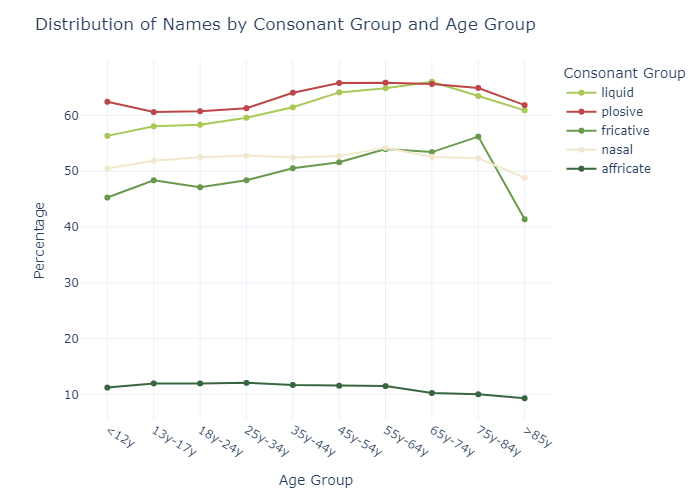

In [ ]:
custom_colors = {
    'affricate': '#386641',
    'fricative': '#6a994e',
    'liquid': '#a7c957',
    'nasal': '#f2e8cf',
    'plosive': '#bc4749'
}

fig = px.line(
    manner_age_df,
    x='age_category',
    y='Percent',
    color='Consonant_Group',
    markers=True,
    color_discrete_map=custom_colors,
    category_orders={'age_category': age_order}
)

fig.update_layout(
    title='Distribution of Names by Consonant Group and Age Group',
    xaxis_title='Age Group',
    yaxis_title='Percentage',
    legend_title='Consonant Group',
    template='plotly_white'
)

fig_path = 'images/plot_15.png'
# fig.write_image(fig_path)
Image(fig_path)


We can see that the affricate group is less present in all ages categories. The percentage of names containing affricate, and nasal groups is stable across generations. The percentage for liquid, plosive and fricative slightly increase with older generations.

### 2.2.e. Name Soundex and N-Gram / Character Features

The Character Names have been processed and these features extracted so they could be used for the predictive models.

## 3. Including Name Origins to the Data Story

We got an external dataset that associates names to their Origin, we'll be using it to predict the Origin of a Name based on it's features :

- **Length**, **Vowel Count** and **Consonant Count** (or the **Vowel/Consonant Ratio**)  
- **First and Last Letters**  
- **Diacritics** (presence of special characters)  
- **Sounded Encoding** (e.g., Soundex patterns)  
- **N-grams (2-3 characters)** for sequential patterns.


In [51]:
# Read and present the data
df_ethnicity = pd.read_csv('data/name_ethnicity.csv')
df_ethnicity = df_ethnicity.rename(columns={"Country": "Origin"})
df_ethnicity.sample(5)

,Name,Origin
11961,Alec,English-Speaking
2052,Otto,English-Speaking
9158,Franco,Romance
7641,Dirk,English-Speaking
2340,Rudolf,English-Speaking


In [52]:
df_ethnicity['Origin'].value_counts()

Origin
English-Speaking    5171
Slavic              3983
Romance             1847
Hispanic             891
East Asian           673
Name: count, dtype: int64

In [53]:
# Extracting the name's characteristics 
processor = NameFeatureProcessor('Name',ngram_range=(2, 3))
ethnicity_processed = processor.process(df_ethnicity)

## 3.1. Finding Patterns between Name Characteristics and the Origin of the Name

### 3.1.a. Name Length, Vowel Count and Consonant Count / Name Origin

In [54]:
ethnicity_processed = ethnicity_processed.rename(columns={'name_length': 'Length', 
                                                                      'vowel_count':'Vowel Count',
                                                                      'consonant_count':'Consonant Count'})

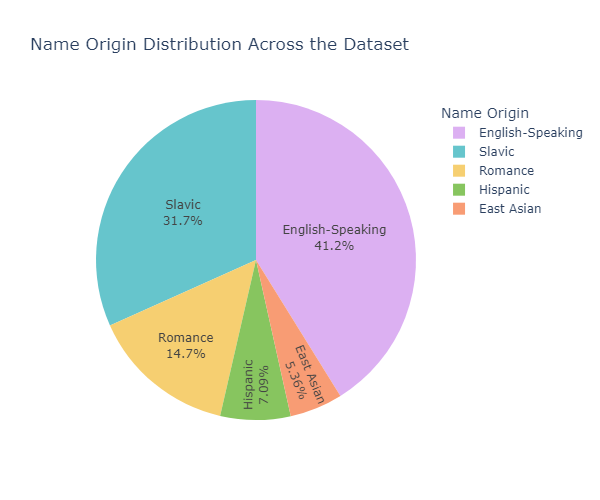

In [ ]:
data = pd.DataFrame({
    'Origin': ethnicity_processed['Origin'],
    'Length': ethnicity_processed['Length'],
    'Vowels/Consonants': ethnicity_processed['Vowel Count']/ethnicity_processed['Consonant Count']
})

# Calculate distribution of origins 
origin_distribution = data['Origin'].value_counts().reset_index()
origin_distribution.columns = ['Origin', 'Count']

unique_origins = data['Origin'].unique()
pastel_colors = px.colors.qualitative.Pastel
color_map = {origin: pastel_colors[i % len(pastel_colors)] for i, origin in enumerate(unique_origins)}

fig = px.pie(
    origin_distribution,
    names='Origin',
    values='Count', 
    title="Name Origin Distribution Across the Dataset",
    color='Origin',
    color_discrete_map=color_map
)

fig.update_traces(
    textinfo='percent+label',  
    hoverinfo='label+percent+value'  
)

fig.update_layout(
    legend_title="Name Origin",
    width=600,
    height=500,
)

fig_path = 'images/plot_16.png'
# fig.write_image(fig_path)
Image(fig_path)


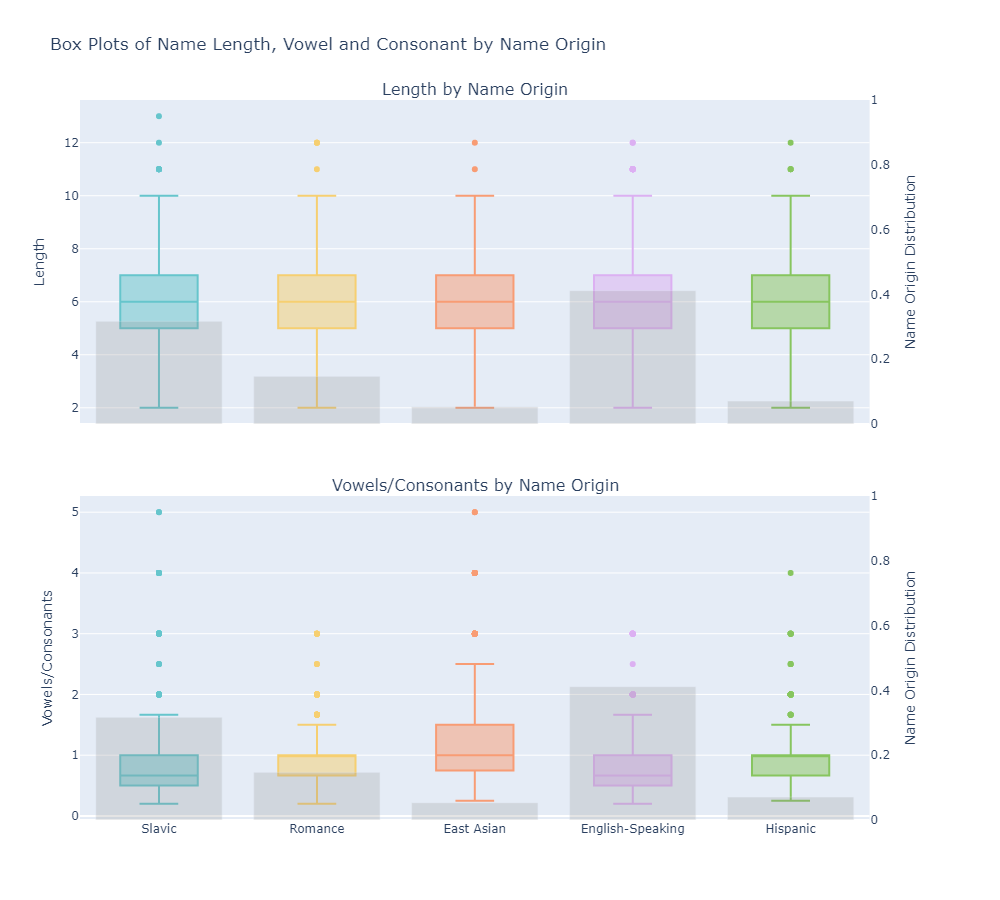

In [ ]:
# Calculate normalized distrib
origin_distribution = data['Origin'].value_counts(normalize=True).reset_index()
origin_distribution.columns = ['Origin', 'Normalized Count']

numerical_columns = ['Length', 'Vowels/Consonants']

fig = make_subplots(
    rows=len(numerical_columns), cols=1,
    subplot_titles=[f"{col} by Name Origin" for col in numerical_columns],
    shared_xaxes=True,
    vertical_spacing=0.1,
    specs=[[{"secondary_y": True}]] * len(numerical_columns)
)

for i, column in enumerate(numerical_columns):
    for ori in unique_origins:
        subset = data[data['Origin'] == ori]
        fig.add_trace(
            go.Box(
                x=[ori] * len(subset),
                y=subset[column],
                name=ori ,
                boxpoints='outliers',
                marker_color=color_map[ori],
                line=dict(color=color_map[ori]),
                showlegend=(i == 0)
            ),
            row=i+1, col=1, secondary_y=False
        )

    fig.add_trace(
        go.Bar(
            x=origin_distribution['Origin'],
            y=origin_distribution['Normalized Count'],
            name="Count",
            marker=dict(color='rgba(150, 150, 150, 0.5)'),
            opacity=0.5
        ),
        row=i+1, col=1, secondary_y=True
    )

fig.update_layout(
    height=900,
    width=1000,
    title_text="Box Plots of Name Length, Vowel and Consonant by Name Origin",
    xaxis_tickangle=225,
    barmode='overlay',
    showlegend=False
)

for i, column in enumerate(numerical_columns):
    fig.update_yaxes(
        title_text="Name Origin Distribution",
        range=[0, 1],
        showgrid=False,
        row=i+1, col=1, secondary_y=True
    )

fig.update_yaxes(title_text="Length", row=1, col=1, secondary_y=False)
fig.update_yaxes(title_text="Vowels/Consonants", row=2, col=1, secondary_y=False)

fig_path = 'images/plot_17.png'
# fig.write_image(fig_path)
Image(fig_path)

Romance, East Asian, and Hispanic names show consistent distributions around a vowels-to-consonants ratio of 1, indicating a balance between vowels and consonants, which may reflect phonetic preferences or linguistic structures favoring smoother, vowel-rich sounds. In contrast, Slavic and English-speaking names tend to have a ratio below 1, suggesting a slight dominance of consonants over vowels. This pattern could be linked to linguistic traits in these languages, such as the use of consonant clusters or less reliance on vowels to form syllables.

### 3.1.b. Name First and Last Letter / Name Origin

In [57]:
alphabet_order = list('ABCDEFGHIJKLMNOPQRSTUVWXYZ')
alphabet_order_lower = [letter.lower() for letter in alphabet_order]

significant_results = []

for letter in alphabet_order_lower:

    contingency_table = pd.crosstab(ethnicity_processed[f'{letter}_f'], ethnicity_processed['Origin'])
    chi2, p, dof, expected = chi2_contingency(contingency_table)
    
    # Chi-2 test
    chi2, p, dof, expected = chi2_contingency(contingency_table)  
    
    # Calculate Cramér's V
    n = contingency_table.sum().sum()
    k = min(contingency_table.shape)
    cramers_v = np.sqrt(chi2 / (n * (k - 1)))
    
    if p < 0.05 and cramers_v > 0.1:
        significant_results.append((letter, p, cramers_v))

print("Names' First Letters with p < 0.05 and Cramér's V > 0.1:")
for letter, p, cramers_v in significant_results:
    print(f"First Letter: {letter}, p-value: {p:.4f}, Cramér's V: {cramers_v:.3f}")

first_significant = sorted(significant_results, key=lambda x: x[2], reverse=True)

Names' First Letters with p < 0.05 and Cramér's V > 0.1:
First Letter: c, p-value: 0.0000, Cramér's V: 0.115
First Letter: f, p-value: 0.0000, Cramér's V: 0.105
First Letter: g, p-value: 0.0000, Cramér's V: 0.112
First Letter: h, p-value: 0.0000, Cramér's V: 0.103
First Letter: i, p-value: 0.0000, Cramér's V: 0.100
First Letter: k, p-value: 0.0000, Cramér's V: 0.146
First Letter: t, p-value: 0.0000, Cramér's V: 0.103
First Letter: v, p-value: 0.0000, Cramér's V: 0.216
First Letter: w, p-value: 0.0000, Cramér's V: 0.115
First Letter: y, p-value: 0.0000, Cramér's V: 0.188
First Letter: z, p-value: 0.0000, Cramér's V: 0.106


C:\Users\amaur\AppData\Local\Temp\ipykernel_7780\3018001456.py:17: RuntimeWarning:

invalid value encountered in divide



In [58]:
alphabet_order = list('ABCDEFGHIJKLMNOPQRSTUVWXYZ')
alphabet_order_lower = [letter.lower() for letter in alphabet_order]

significant_results = []

for letter in alphabet_order_lower:

    contingency_table = pd.crosstab(ethnicity_processed[f'{letter}_l'], ethnicity_processed['Origin'])
    chi2, p, dof, expected = chi2_contingency(contingency_table)
    
    # Chi-2 testing
    chi2, p, dof, expected = chi2_contingency(contingency_table)
    
    # Cramér's V
    n = contingency_table.sum().sum()
    k = min(contingency_table.shape)
    cramers_v = np.sqrt(chi2 / (n * (k - 1)))
    
    # Significant results
    if p < 0.05 and cramers_v > 0.1:
        significant_results.append((letter, p, cramers_v))

# Add significant results
print("Names' Last Letters with p < 0.05 and Cramér's V > 0.1:")
for letter, p, cramers_v in significant_results:
    print(f"Last Letter: {letter}, p-value: {p:.4f}, Cramér's V: {cramers_v:.3f}")

last_significant = sorted(significant_results, key=lambda x: x[2], reverse=True)

Names' Last Letters with p < 0.05 and Cramér's V > 0.1:
Last Letter: a, p-value: 0.0000, Cramér's V: 0.190
Last Letter: d, p-value: 0.0000, Cramér's V: 0.137
Last Letter: e, p-value: 0.0000, Cramér's V: 0.161
Last Letter: g, p-value: 0.0000, Cramér's V: 0.173
Last Letter: h, p-value: 0.0000, Cramér's V: 0.101
Last Letter: i, p-value: 0.0000, Cramér's V: 0.275
Last Letter: n, p-value: 0.0000, Cramér's V: 0.108
Last Letter: o, p-value: 0.0000, Cramér's V: 0.383
Last Letter: r, p-value: 0.0000, Cramér's V: 0.149
Last Letter: t, p-value: 0.0000, Cramér's V: 0.102
Last Letter: u, p-value: 0.0000, Cramér's V: 0.162
Last Letter: v, p-value: 0.0000, Cramér's V: 0.140
Last Letter: y, p-value: 0.0000, Cramér's V: 0.101


C:\Users\amaur\AppData\Local\Temp\ipykernel_7780\4000210768.py:17: RuntimeWarning:

invalid value encountered in divide



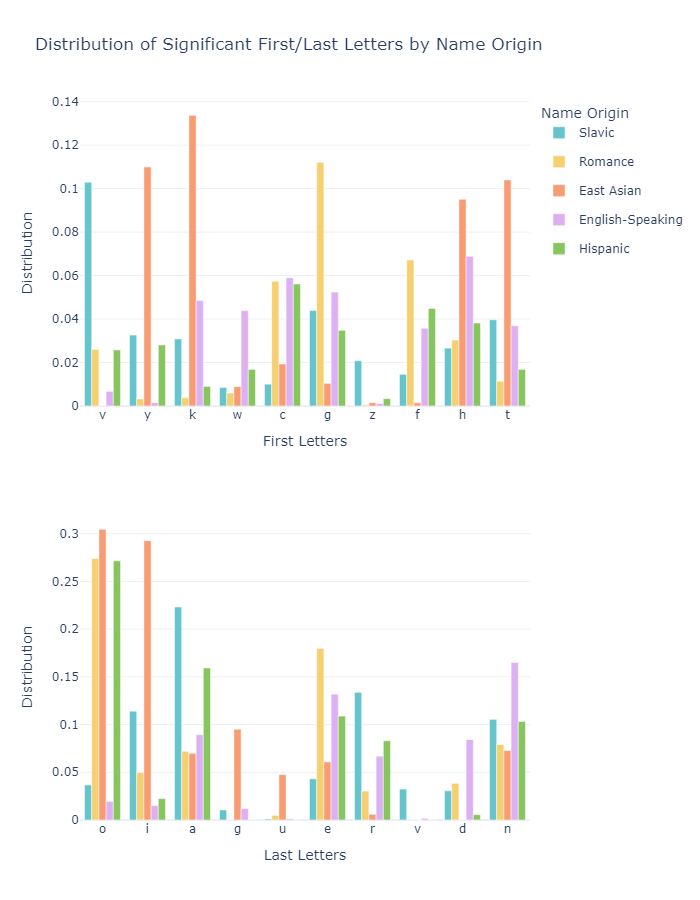

In [ ]:
# 4 most significant first and last letters
top_first_letters = [x[0] for x in first_significant[:10]]
top_last_letters = [x[0] for x in last_significant[:10]]

results_first = []
results_last = []

def calculate_distribution(letters, position, results_list):
    for letter in letters:
        column_name = f'{letter}_{position}'
        if column_name in ethnicity_processed.columns:
            contingency_table = pd.crosstab(ethnicity_processed[column_name], ethnicity_processed['Origin'])
            contingency_table['Total'] = contingency_table.sum(axis=1)

            total_0 = contingency_table.loc[0] if 0 in contingency_table.index else 0
            total_1 = contingency_table.loc[1] if 1 in contingency_table.index else 0

            for origin in contingency_table.columns[:-1]:
                results_list.append({
                    'Origin': origin,
                    'Letter': letter,
                    'Total_0': total_0[origin] if isinstance(total_0, pd.Series) else 0,
                    'Total_1': total_1[origin] if isinstance(total_1, pd.Series) else 0,
                    'Total': (total_0[origin] if isinstance(total_0, pd.Series) else 0) + 
                             (total_1[origin] if isinstance(total_1, pd.Series) else 0)
                })

calculate_distribution(top_first_letters, 'f', results_first)
calculate_distribution(top_last_letters, 'l', results_last)

results_first_df = pd.DataFrame(results_first)
results_last_df = pd.DataFrame(results_last)

results_first_df['Distribution per Origin'] = results_first_df['Total_1'] / results_first_df['Total']
results_last_df['Distribution per Origin'] = results_last_df['Total_1'] / results_last_df['Total']

origins_order = ['Slavic', 'Romance', 'East Asian','English-Speaking', 'Hispanic']
pastel_colors = pc.qualitative.Pastel
color_map = {origin: pastel_colors[i % len(pastel_colors)] for i, origin in enumerate(origins_order)}

results_first_df['Origin'] = pd.Categorical(results_first_df['Origin'], categories=origins_order, ordered=True)
results_last_df['Origin'] = pd.Categorical(results_last_df['Origin'], categories=origins_order, ordered=True)

fig = make_subplots(
    rows=2, cols=1, 
    shared_xaxes=False, 
    shared_yaxes=False
)

for origin in origins_order:
    filtered_data = results_first_df[results_first_df['Origin'] == origin]
    fig.add_trace(
        go.Bar(
            x=filtered_data['Letter'],
            y=filtered_data['Distribution per Origin'],
            name=origin,  
            legendgroup=origin,
            marker=dict(color=color_map[origin])
        ),
        row=1, col=1
    )

for origin in origins_order:
    filtered_data = results_last_df[results_last_df['Origin'] == origin]
    fig.add_trace(
        go.Bar(
            x=filtered_data['Letter'],
            y=filtered_data['Distribution per Origin'],
            name=origin,  
            legendgroup=origin,  
            showlegend=False,
            marker=dict(color=color_map[origin])
        ),
        row=2, col=1
    )

fig.update_layout(
    height=900,
    title_text="Distribution of Significant First/Last Letters by Name Origin",
    template="plotly_white",
    barmode="group",  
    legend_title="Name Origin",
)

fig.update_xaxes(title_text="First Letters", row=1, col=1)
fig.update_xaxes(title_text="Last Letters", row=2, col=1)
fig.update_yaxes(title_text="Distribution", row=1, col=1)
fig.update_yaxes(title_text="Distribution", row=2, col=1)

fig_path = 'images/plot_18.png'
# fig.write_image(fig_path)
Image(fig_path)

### 3.1.c. Name Diacritics / Name Origin

In [60]:
# Diacritic characters
diacritics_set = set("üéèäöÃëçÖïáéäÔþçÁøõãæšáàÂùðìôêÖØÀûßýÉïåÓúśíłÅÞūžâÍÈëōîñüèóöÕò")

significant_results = []

for letter in diacritics_set:
    if f'{letter}' in ethnicity_processed.columns:  
        contingency_table = pd.crosstab(ethnicity_processed[f'{letter}'], ethnicity_processed['Origin'])
        chi2, p, dof, expected = chi2_contingency(contingency_table)

        # Chi-2
        chi2, p, dof, expected = chi2_contingency(contingency_table)  

        # Cramér's V
        n = contingency_table.sum().sum()
        k = min(contingency_table.shape)
        cramers_v = np.sqrt(chi2 / (n * (k - 1)))

        # Significant results
        if p < 0.05 and cramers_v > 0.05:
            significant_results.append((letter, p, cramers_v))

# Display significant results
print("Names' First Letters with p < 0.05 and Cramér's V > 0.1:")
for letter, p, cramers_v in significant_results:
    print(f"First Letter: {letter}, p-value: {p:.4f}, Cramér's V: {cramers_v:.3f}")

significant = sorted(significant_results, key=lambda x: x[2], reverse=True)

Names' First Letters with p < 0.05 and Cramér's V > 0.1:
First Letter: é, p-value: 0.0000, Cramér's V: 0.157
First Letter: è, p-value: 0.0000, Cramér's V: 0.071
First Letter: ö, p-value: 0.0000, Cramér's V: 0.076
First Letter: ü, p-value: 0.0000, Cramér's V: 0.051


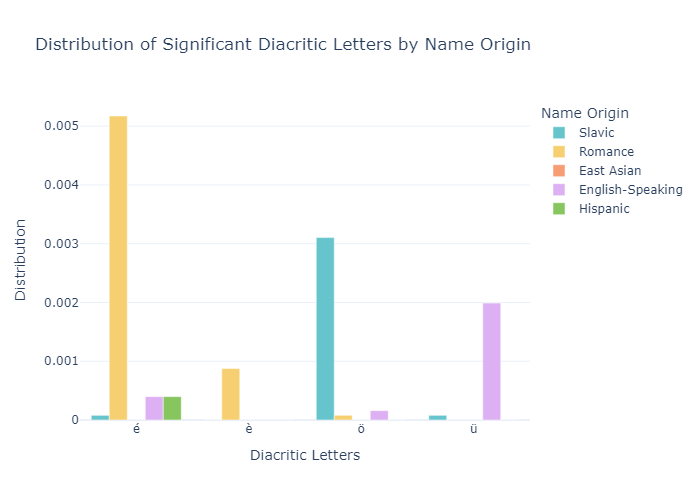

In [ ]:
# List of significant diacritics
top_diacritics = [x[0] for x in significant_results]

results = []
for letter in top_diacritics:
    column_name = f'{letter}'
    if column_name in ethnicity_processed.columns:  
        contingency_table = pd.crosstab(ethnicity_processed[column_name], ethnicity_processed['Origin'])
        contingency_table['Total'] = contingency_table.sum(axis=1)
        
        total_1 = contingency_table.loc[1] if 1 in contingency_table.index else 0
        for origin in contingency_table.columns[:-1]:
            results.append({
                'Origin': origin,
                'Letter': letter,
                'Count': total_1[origin],
                'Distribution': total_1[origin] / contingency_table['Total'].sum()
            })

results_df = pd.DataFrame(results)

fig = go.Figure()

results_df['Origin'] = pd.Categorical(results_df['Origin'], categories=origins_order, ordered=True)

for origin in origins_order:
    filtered_data = results_df[results_df['Origin'] == origin]
    fig.add_trace(
        go.Bar(
            x=filtered_data['Letter'],
            y=filtered_data['Distribution'],
            name=origin,
            marker=dict(color=color_map[origin])
        )
    )

fig.update_layout(
    title="Distribution of Significant Diacritic Letters by Name Origin",
    xaxis_title="Diacritic Letters",
    yaxis_title="Distribution",
    barmode="group",
    template="plotly_white",
    legend_title="Name Origin",
    xaxis=dict(tickmode="linear"),
    yaxis=dict(showgrid=True)
)

fig_path = 'images/plot_19.png'
# fig.write_image(fig_path)
Image(fig_path)

### 3.1.e Consonant Group / Name Origin

In [62]:
# We will divide consonants by their manner of articulation
plosive = ['P', 'T', 'B', 'K']
fricative = ['F', 'X', '0', 'S', 'H']
affricate = ['J']
nasal = ['M', 'N']
liquid = ['L', 'R']
manner_groups = [plosive, fricative, affricate, nasal, liquid]
manner_names = ['plosive', 'fricative', 'affricate', 'nasal', 'liquid']

In [63]:
analyze_phonetics = PhoneticAnalyzer(df_ethnicity, manner_groups, manner_names, 'Name')
manner_df = analyze_phonetics.phonetics_by_origin()

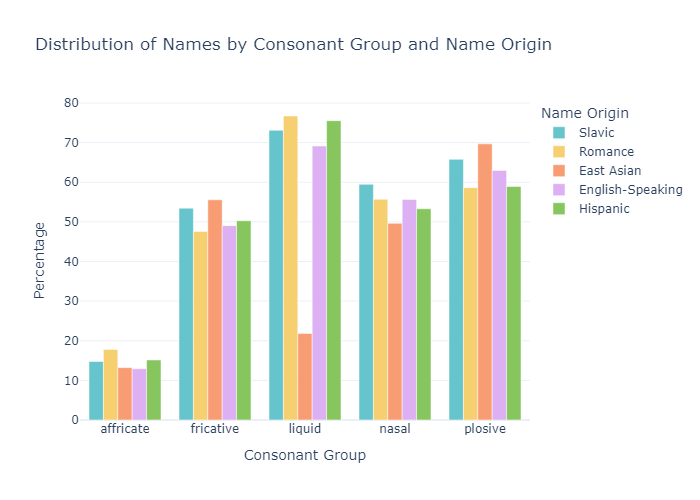

In [64]:
ordered_origins = ['Slavic', 'Romance', 'East Asian', 'English-Speaking', 'Hispanic']
pastel_colors = px.colors.qualitative.Pastel
color_map = {origin: pastel_colors[i % len(pastel_colors)] for i, origin in enumerate(ordered_origins)}

fig = go.Figure()

for origin in ordered_origins:
    filtered_df = manner_df[manner_df['Origin'] == origin]
    fig.add_trace(go.Bar(
        x=filtered_df['Consonant_Group'],
        y=filtered_df['Percent'],
        name=origin,
        marker_color=color_map[origin]
    ))

fig.update_layout(
    title='Distribution of Names by Consonant Group and Name Origin',
    xaxis_title='Consonant Group',
    yaxis_title='Percentage',
    barmode='group',
    legend_title='Name Origin',
    template='plotly_white'
)

fig_path = 'images/plot_20.png'
# fig.write_image(fig_path)
Image(fig_path)

The plot above shows that plosives, fricatives, and affricates sounds are more common in male character names while nasal and liquid names are more common for female character names. Although not formally defined from a linguistic point of view, we can regroup plosives, fricatives and affricates sounds as 'hard' sounds and nasal and liquid sounds as 'soft' sounds. From this, we can deduce that male names are more likely to contain 'hard' sounds and female names 'soft' sounds.

### 3.1.d. Name Soundex and N-Gram / Name Origin

Dire que c'est ajouté au modèle

## 3.2. Name Origin Machine Learning Model  

Ajouter la partie sur ca

# 4. Sentimental Analysis to get Character Morality (Nice/Bad)

This section marks the beginning of the Sentiment Analysis, focusing particularly on the preprocessing of the movies synopsies dataset. For each character in every movie, the goal was to identify the sentences involving them directly in the summaries using natural language processing (NLP).

To run this part, you will need to download the `corenlp_plot_summaries` locally, as we couldn't import it in the repository. You can find the result of our prepropccessing as `sentences_by_characters.csv` in the `data` folder. 

In [65]:
df = pd.read_csv('data/sentences_by_character.csv')
print(df.shape)

(55863, 4)


## 4.1. Analysing the results

## 4.1.a. Functions for TextBlob SA

TextBlob uses two key metrics for sentiment analysis: Polarity and Subjectivity.

- **Polarity (P):** Measures sentiment on a scale from **-1** (most negative) to **1** (most positive).
- **Subjectivity (S):** Measures how subjective or objective the sentiment is, ranging from **0** (most objective) to **1** (most subjective).


| Polarity (P)    | Subjectivity (S) | Interpretation                |
|---------------------|------------------------|------------------------------------|
| [-1; -0.5]      | [0.5; 1]           | Very Negative & Subjective        |
| [-0.5; 0]       | [0; 0.5]           | Negative but Fairly Objective     |
| 0               | [0; 1]             | Neutral                           |
| [0; 0.5]        | [0; 0.5]           | Positive but Fairly Objective     |
| [0.5; 1]        | [0.5; 1]           | Very Positive & Subjective        |

In [66]:
df_sentiment_analysis_textblob = pd.read_csv('data/sentimental_analysis.csv')
df_sentiment_analysis_textblob.sample(5)

,Character_Name,Wikipedia_id,Polarity,Subjectivity
30326,Beth,7225213,0.035000,0.125000
43514,Harbans,20435857,0.037016,0.186574
26298,Alma,5191706,0.080668,0.290303
23424,Avoca,3965064,0.050000,0.300000
18217,Vito,2466773,-0.006846,0.164113


## 4.1.b. Interpretation of the results

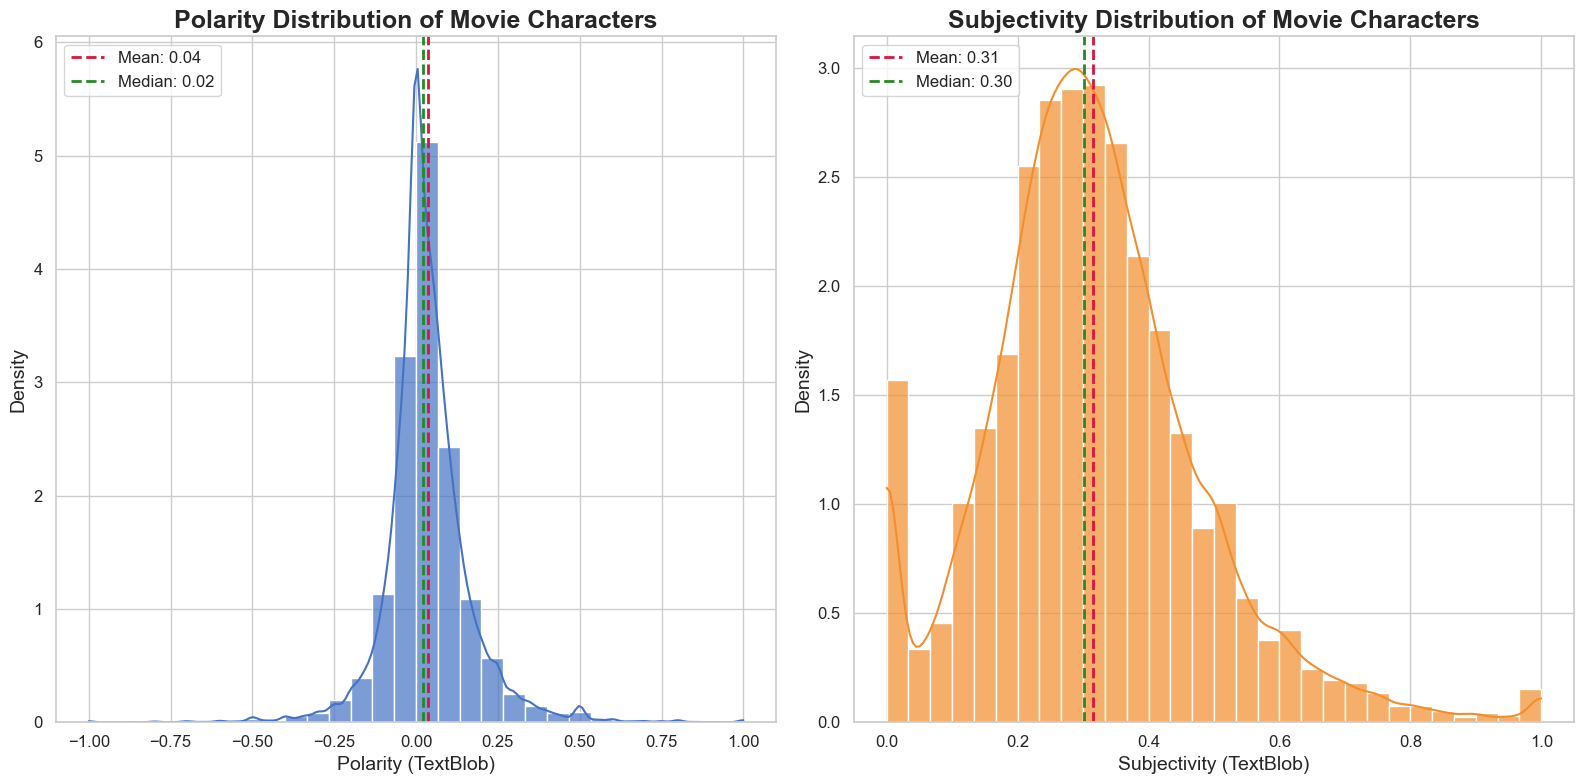

In [106]:
sns.set_theme(style="whitegrid")

plt.figure(figsize=(16, 8))

# Polarity Distribution Plot
plt.subplot(1, 2, 1)
sns.histplot(
    df_sentiment_analysis_textblob['Polarity'], 
    kde=True, color='#4472C4', bins=30, stat='density', alpha=0.7
)
mean_pol = df_sentiment_analysis_textblob['Polarity'].mean()
median_pol = df_sentiment_analysis_textblob['Polarity'].median()

# Add statistical annotations
plt.axvline(mean_pol, color='crimson', linestyle='--', linewidth=2, label=f'Mean: {mean_pol:.2f}')
plt.axvline(median_pol, color='forestgreen', linestyle='--', linewidth=2, label=f'Median: {median_pol:.2f}')
plt.title('Polarity Distribution of Movie Characters', fontsize=18, weight='bold')
plt.xlabel('Polarity (TextBlob)', fontsize=14)
plt.ylabel('Density', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=12, loc='upper left')

plt.subplot(1, 2, 2)
sns.histplot(
    df_sentiment_analysis_textblob['Subjectivity'], 
    kde=True, color='#F28E2B', bins=30, stat='density', alpha=0.7
)
mean_sub = df_sentiment_analysis_textblob['Subjectivity'].mean()
median_sub = df_sentiment_analysis_textblob['Subjectivity'].median()

# Add statistical annotations
plt.axvline(mean_sub, color='crimson', linestyle='--', linewidth=2, label=f'Mean: {mean_sub:.2f}')
plt.axvline(median_sub, color='forestgreen', linestyle='--', linewidth=2, label=f'Median: {median_sub:.2f}')
plt.title('Subjectivity Distribution of Movie Characters', fontsize=18, weight='bold')
plt.xlabel('Subjectivity (TextBlob)', fontsize=14)
plt.ylabel('Density', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=12, loc='upper left')

plt.tight_layout()

In [68]:
from scipy.stats import pearsonr, shapiro

# Calcul of the Pearson correlation coefficient
correlation, _ = pearsonr(df_sentiment_analysis_textblob["Polarity"], df_sentiment_analysis_textblob["Subjectivity"])
print(f"Pearson Correlation: {correlation:.2f}")

Pearson Correlation: 0.19


The weak **Pearson correlation** of 0.19 between polarity and subjectivity indicates that these two variables are not strongly related. While there may be some minor associations, they largely function independently. Given this independence, we will now primarily focus on polarity in our analysis as follow:

| Polarity (P)    | Interpretation                |
|---------------------|------------------------|
| [-1; -0.5]      | Very bad guy: You arch-nemesis, you'd rather fight a bear than run into him/her !        |
| [-0.5; 0]       | Bad guy: That person you politely tolerate, but "let's not get too close".     |
| 0               | Neutral, that random person in the elevator you nod at.                          |
| [0; 0.5]        | Nice guy: Your chill buddy you'd grab coffee with :)      |
| [0.5; 1]        | Very nice guy: Your ultimate-ride-or-die BFF, partner in crime !        |

In [69]:
df_sentiment_analysis_textblob['Interpretation_SA'] = df_sentiment_analysis_textblob['Polarity'].apply(interpret_polarity)
df_sentiment_analysis_textblob.sample(5)

,Character_Name,Wikipedia_id,Polarity,Subjectivity,Interpretation_SA
20192,Gregg,2969247,0.000000,0.000000,Neutral
23185,Jonathan,3874380,0.014167,0.185833,Nice guy
24017,Zebrata,4201066,-0.300000,0.650000,Bad guy
25731,Krishnaveni,4971555,-0.075000,0.162500,Bad guy
16414,Jessie,2080306,0.002654,0.220031,Nice guy


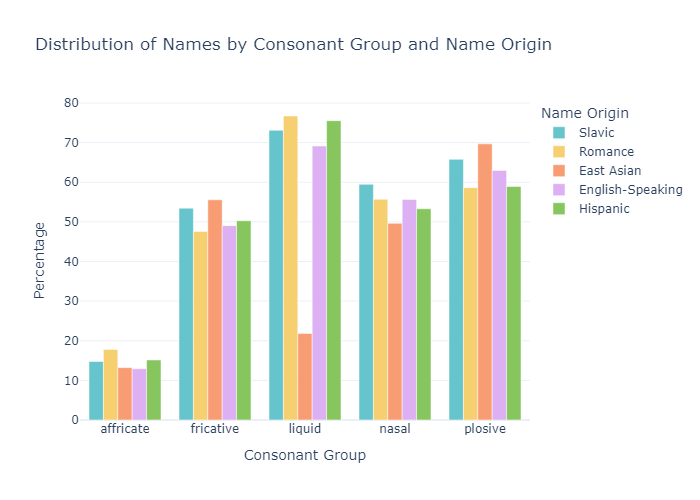

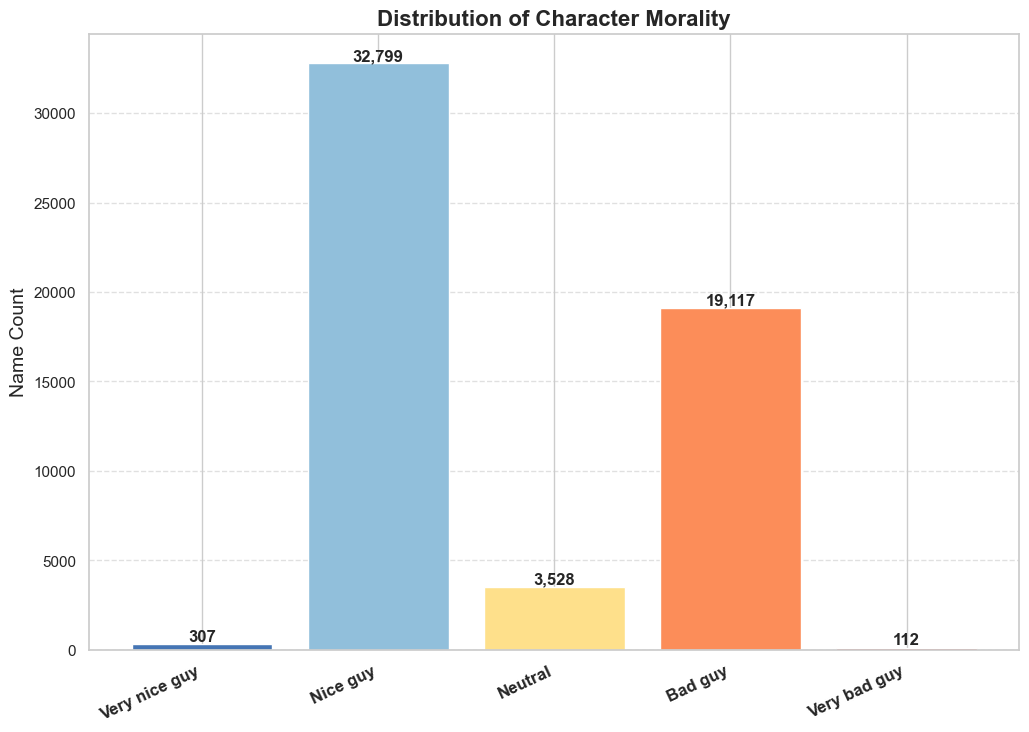

In [70]:
# Define the order of categories
desired_order = ["Very nice guy", "Nice guy", "Neutral", "Bad guy", "Very bad guy"]

# Count interpretations and reorder
interpretation_counts = df_sentiment_analysis_textblob['Interpretation_SA'].value_counts()

interpretation_counts = interpretation_counts.reindex(desired_order)

plt.figure(figsize=(12, 8))
bars = plt.bar(
    interpretation_counts.index, 
    interpretation_counts.values, 
    color=['#4575b4', '#91bfdb', '#fee08b', '#fc8d59', '#d73027']
)

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height, f'{height:,}', 
             ha='center', va='bottom', fontsize=12, fontweight='bold')

plt.title('Distribution of Character Morality', fontsize=16, fontweight='bold')
plt.ylabel('Name Count', fontsize=14)
plt.xticks(rotation=25, ha='right', fontsize=12, fontweight='bold')
plt.grid(axis='y', linestyle='--', alpha=0.6)

fig_path = 'images/plot_22.png'
# fig.write_image(fig_path)
Image(fig_path)

Addition of the Sentimental Analysis to the original cleaned dataset : 

In [71]:
character_names_processed_sa = pd.merge(
    character_names_processed,
    df_sentiment_analysis_textblob,
    left_on=['Wikipedia_ID', 'Character_name'],
    right_on=['Wikipedia_id', 'Character_Name'],
    how='left',  
    suffixes=('', '_sentiment')  
)

character_names_processed_sa.drop(['Subjectivity', 'Wikipedia_id', 'Character_Name'], axis=1, inplace=True)

character_names_processed_sa = character_names_processed_sa.dropna(subset=['Interpretation_SA'], inplace=False)

character_names_processed_sa['Interpretation_SA'] = character_names_processed_sa['Interpretation_SA'].replace({
    'Very nice guy': 'Nice guy',
    'Very bad guy': 'Bad guy' 
})

## 4.2. Finding Patterns between Name Characteristics and Character Morality

In [72]:
analyze_SA = GoodBadGuyAnalyzer(character_names_processed_sa)

bad_guys_names, bad_girls_names = analyze_SA.get_bad_guys_girls_names_SA(8)
good_guys_names, good_girls_names = analyze_SA.get_good_guys_girls_names_SA(8)

data_f_bad = analyze_SA.create_sunburst_data_SA(bad_girls_names)
data_f_good = analyze_SA.create_sunburst_data_SA(good_girls_names)

data_m_bad = analyze_SA.create_sunburst_data_SA(bad_guys_names)
data_m_good = analyze_SA.create_sunburst_data_SA(good_guys_names)

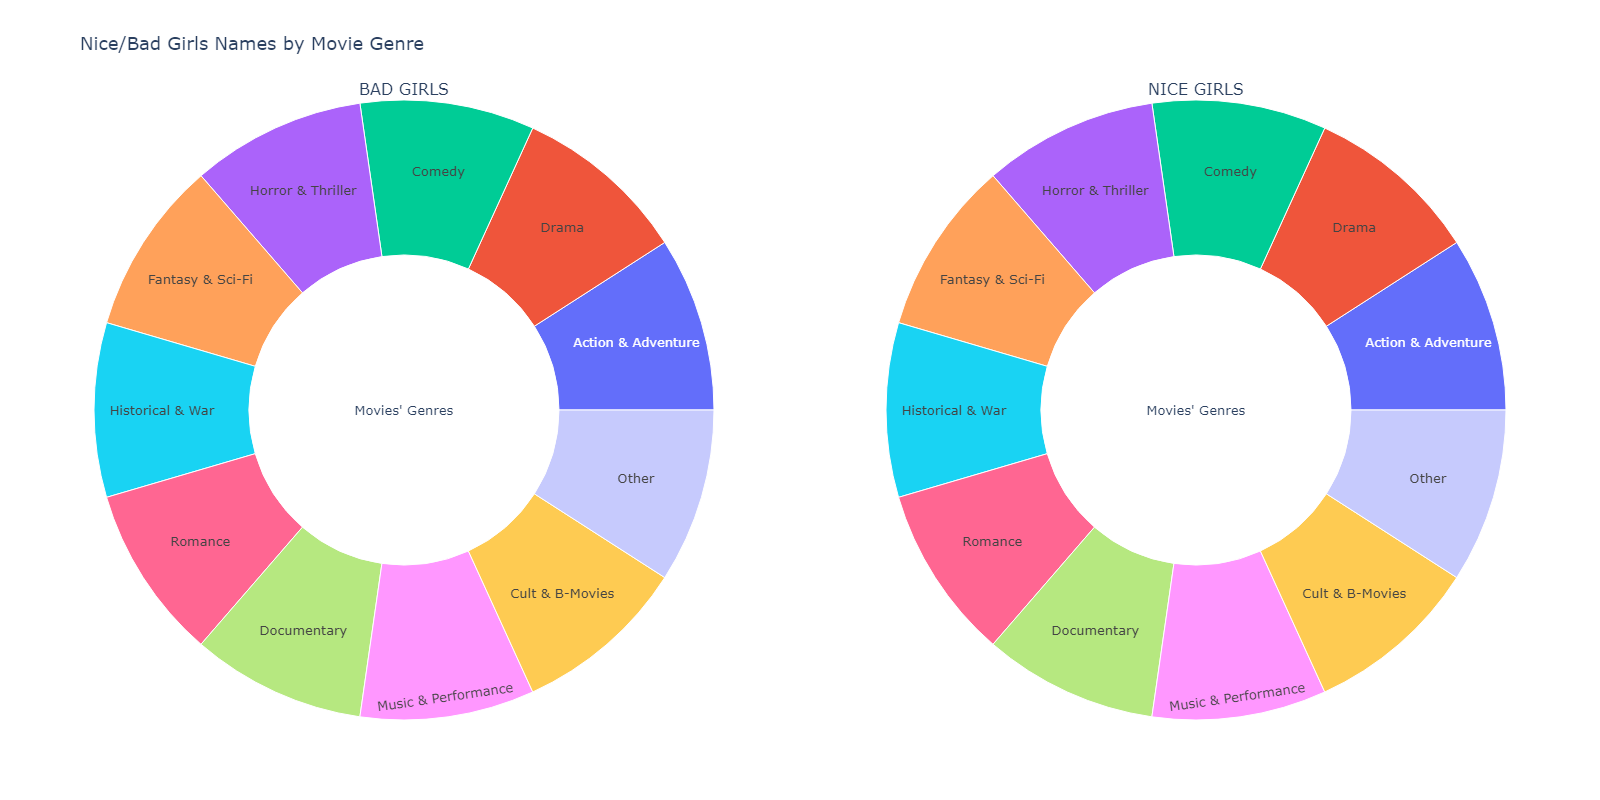

In [73]:
# Create the sunburst plots for females and males
fig_bad_girls = go.Figure(go.Sunburst(
    labels=data_f_bad['character'],
    parents=data_f_bad['parent'],
    domain=dict(column=1),
    maxdepth=2,
    hovertemplate="Nice Girls<br>%{label}<extra></extra>"  
))

fig_good_girls = go.Figure(go.Sunburst(
    labels=data_f_good['character'],
    parents=data_f_good['parent'],
    domain=dict(column=1),
    maxdepth=2,
    hovertemplate="Bad Girls<br>%{label}<extra></extra>"  
))

fig = make_subplots(
    rows=1, cols=2,
    subplot_titles=["BAD GIRLS", "NICE GIRLS"],
    specs=[[{"type": "sunburst"}, {"type": "sunburst"}]]
)

fig.add_trace(fig_good_girls['data'][0], row=1, col=1)
fig.add_trace(fig_bad_girls['data'][0], row=1, col=2)

fig.update_layout(
    title_text="Nice/Bad Girls Names by Movie Genre",
    showlegend=False,
    width=1600,
    height=800,
    font=dict(size=13)
)

fig_path = 'images/plot_23.png'
# fig.write_image(fig_path)
Image(fig_path)

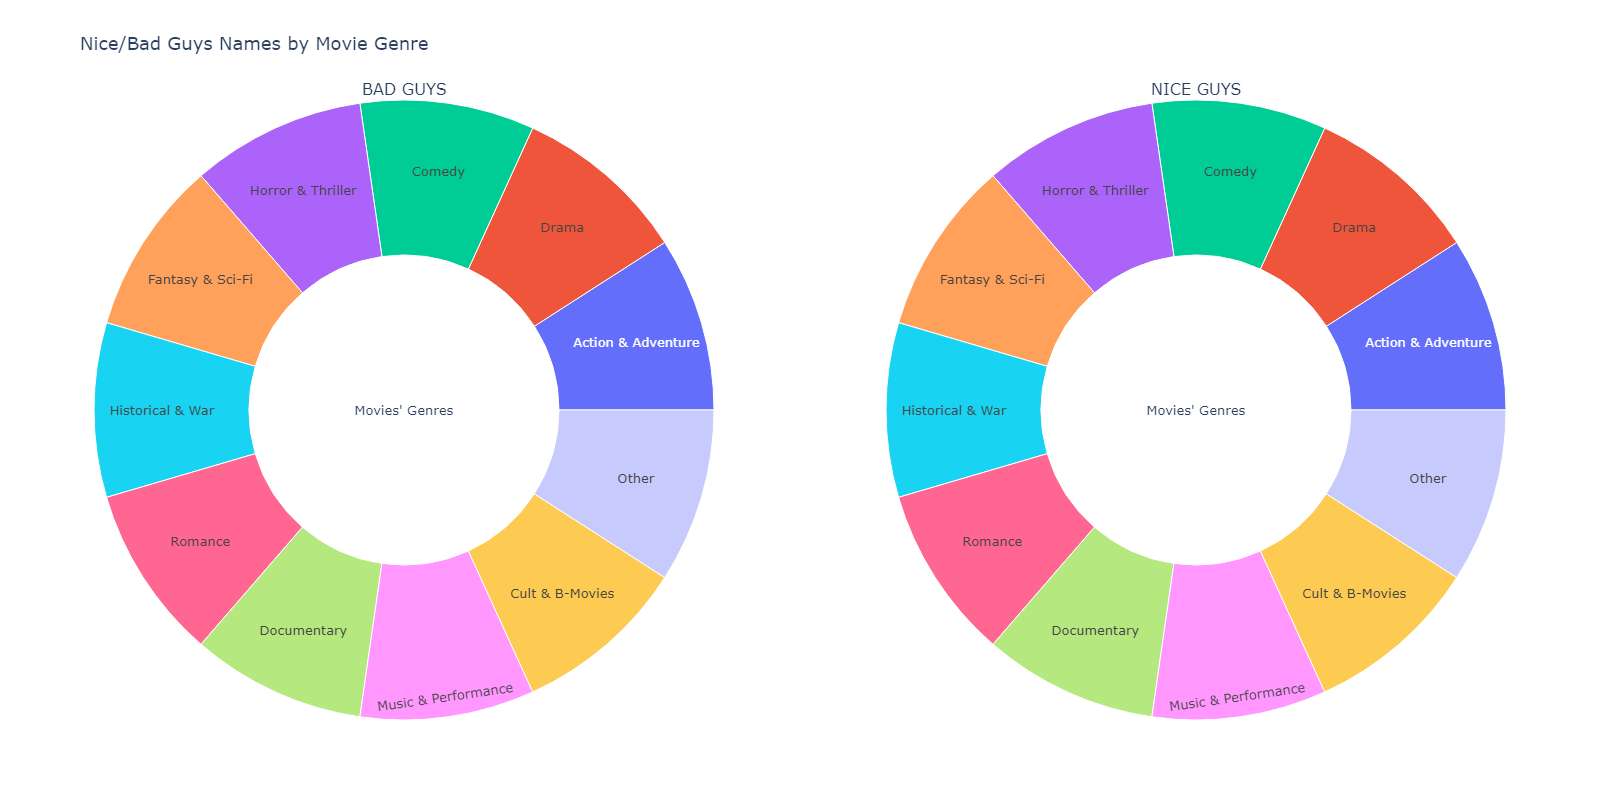

In [74]:
# Create the sunburst plots for males (bad and good)
fig_bad_guys = go.Figure(go.Sunburst(
    labels=data_m_bad['character'],
    parents=data_m_bad['parent'],
    domain=dict(column=1),
    maxdepth=2,
    hovertemplate="Nice Guys<br>%{label}<extra></extra>"  
))

fig_good_guys = go.Figure(go.Sunburst(
    labels=data_m_good['character'],
    parents=data_m_good['parent'],
    domain=dict(column=1),
    maxdepth=2,
    hovertemplate="Bad Guys<br>%{label}<extra></extra>"  
))

fig = make_subplots(
    rows=1, cols=2,
    subplot_titles=["BAD GUYS", "NICE GUYS"],
    specs=[[{"type": "sunburst"}, {"type": "sunburst"}]]
)

fig.add_trace(fig_good_guys['data'][0], row=1, col=1)
fig.add_trace(fig_bad_guys['data'][0], row=1, col=2)

fig.update_layout(
    title_text="Nice/Bad Guys Names by Movie Genre",
    showlegend=False,
    width=1600,
    height=800,
    font=dict(size=13)
)

fig_path = 'images/plot_24.png'
# fig.write_image(fig_path)
Image(fig_path)

### 4.2.a. Name Length, Vowel Count and Consonant Count / Character Morality

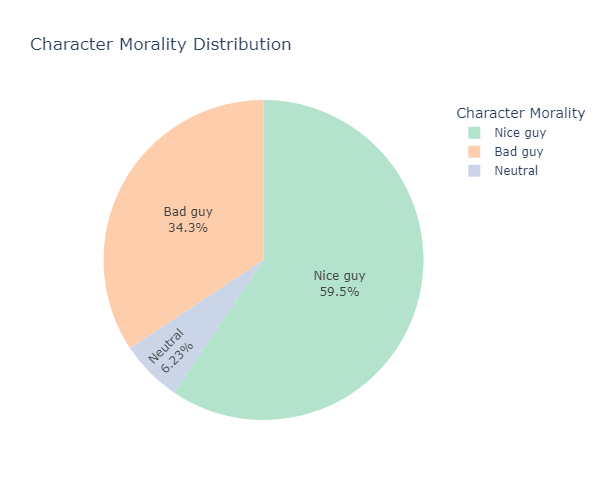

In [75]:
data = pd.DataFrame({
    'Nice/Neutral/Bad Guy': character_names_processed_sa['Interpretation_SA'],  
    'Length': character_names_processed_sa['Length'],
    'Vowel Count': character_names_processed_sa['Vowel Count'],
    'Consonant Count': character_names_processed_sa['Consonant Count']
})

# Calculate the distribution of character types (using actual counts)
character_type_distribution = data['Nice/Neutral/Bad Guy'].value_counts().reset_index()
character_type_distribution.columns = ['Character Morality', 'Count']

pastel1_colors = {
    'Nice guy': '#B3E2CD',  # Light green
    'Bad guy': '#FDCDAC',   # Light red
    'Neutral': '#CBD5E8'    # Light blue
}

# Create the pie chart for character type distribution
fig_pie = px.pie(
    character_type_distribution,
    names='Character Morality',
    values='Count',  
    title="Character Morality Distribution",
    color='Character Morality',
    color_discrete_map=pastel1_colors  
)

fig_pie.update_traces(
    textinfo='percent+label',  
    hoverinfo='label+percent+value'  
)

fig_pie.update_layout(
    legend_title="Character Morality",
    width=600,
    height=500,
)

fig_path = 'images/plot_25.png'
# fig_pie.write_image(fig_path)
Image(fig_path)

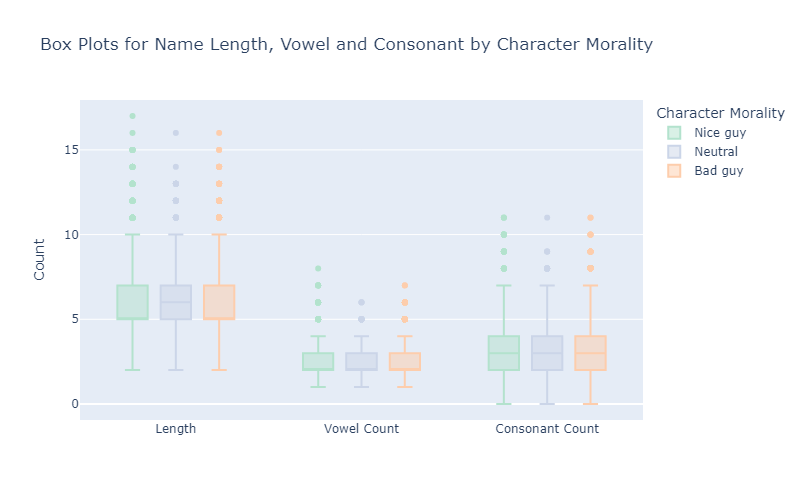

In [ ]:
data = pd.DataFrame({
    'Character Morality': character_names_processed_sa['Interpretation_SA'],  
    'Length': character_names_processed_sa['Length'],
    'Vowel Count': character_names_processed_sa['Vowel Count'],
    'Consonant Count': character_names_processed_sa['Consonant Count']
})

data_long = data.melt(id_vars=['Character Morality'], 
                      value_vars=['Length', 'Vowel Count', 'Consonant Count'], 
                      var_name='Feature', value_name='Value')

fig = px.box(data_long, 
             x='Feature', 
             y='Value', 
             color='Character Morality',
             color_discrete_map=pastel1_colors,
             title="Box Plots for Name Length, Vowel and Consonant by Character Morality",
             category_orders={"Character Morality": ["Nice guy", "Neutral", "Bad guy"]}  
)

fig.update_layout(
    yaxis_title="Count",
    xaxis_title=None,
    width=800,
    height=500,
    legend_title="Character Morality"
)

fig_path = 'images/plot_26.png'
# fig.write_image(fig_path)
Image(fig_path)

In [77]:
length_good = character_names_processed_sa[character_names_processed_sa['Interpretation_SA'] == 'Nice guy']['Length']
length_bad = character_names_processed_sa[character_names_processed_sa['Interpretation_SA'] == 'Bad guy']['Length']

vow_good = character_names_processed_sa[character_names_processed_sa['Interpretation_SA'] == 'Nice guy']['Vowel Count']
vow_bad = character_names_processed_sa[character_names_processed_sa['Interpretation_SA'] == 'Bad guy']['Vowel Count']

cons_good = character_names_processed_sa[character_names_processed_sa['Interpretation_SA'] == 'Nice guy']['Consonant Count']
cons_bad = character_names_processed_sa[character_names_processed_sa['Interpretation_SA'] == 'Bad guy']['Consonant Count']

# T-Test
print("Length:")
t_stat, p_value = ttest_ind(length_m, length_f, equal_var=False)  
print(f"T-statistique : {t_stat:.4f}")
print(f"P-value : {p_value}\n")

print("Vowel Count:")
t_stat, p_value = ttest_ind(vow_m, vow_f, equal_var=False)  
print(f"T-statistique : {t_stat:.4f}")
print(f"P-value : {p_value}\n")

print("Consonant Count:")
t_stat, p_value = ttest_ind(cons_m, cons_f, equal_var=False)  
print(f"T-statistique : {t_stat:.4f}")
print(f"P-value : {p_value}")

Length:
T-statistique : -1.5946
P-value : 0.1108029382792036

Vowel Count:
T-statistique : -73.3187
P-value : 0.0

Consonant Count:
T-statistique : 46.6738
P-value : 0.0


In [78]:
# Calculate mean and standard deviation for Length
length_stats = character_names_processed_sa.groupby('Interpretation_SA').agg(
    Mean_Length=('Length', 'mean'),
    Std_Length=('Length', 'std')
).reset_index()

length_stats.rename(columns={
    'Interpretation_SA': 'Character Morality',
    'Mean_Length': 'Average Length',
    'Std_Length': 'Length Std'
}, inplace=True)

print("Length Statistics by Character Morality :")
length_stats.head()

Length Statistics by Character Morality :


,Character Morality,Average Length,Length Std
0,Bad guy,5.658404,1.689614
1,Neutral,5.803005,1.793140
2,Nice guy,5.695151,1.713097


In [79]:
# Calculate mean and standard deviation for Vowel Count
vowel_stats = character_names_processed_sa.groupby('Interpretation_SA').agg(
    Mean_Vowel_Count=('Vowel Count', 'mean'),
    Std_Vowel_Count=('Vowel Count', 'std')
).reset_index()

vowel_stats.rename(columns={
    'Interpretation_SA': 'Character Morality',
    'Mean_Vowel_Count': 'Average Vowel Count',
    'Std_Vowel_Count': 'Vowel Count Std'
}, inplace=True)

print("Vowel Count Statistics by Character Morality :")
vowel_stats.head()

Vowel Count Statistics by Character Morality :


,Character Morality,Average Vowel Count,Vowel Count Std
0,Bad guy,2.343877,0.836084
1,Neutral,2.410929,0.879757
2,Nice guy,2.376999,0.850869


In [80]:
# Calculate mean and standard deviation for Consonant Count
consonant_stats = character_names_processed_sa.groupby('Interpretation_SA').agg(
    Mean_Consonant_Count=('Consonant Count', 'mean'),
    Std_Consonant_Count=('Consonant Count', 'std')
).reset_index()

consonant_stats.rename(columns={
    'Interpretation_SA': 'Character Morality',
    'Mean_Consonant_Count': 'Average Consonant Count',
    'Std_Consonant_Count': 'Consonant Count Std'
}, inplace=True)

print("Consonant Count Statistics by Character Morality :")
consonant_stats.head()

Consonant Count Statistics by Character Morality :


,Character Morality,Average Consonant Count,Consonant Count Std
0,Bad guy,3.314427,1.254471
1,Neutral,3.391257,1.306711
2,Nice guy,3.318095,1.267416


### 4.2.b. Name First and Last Letter / Character Morality

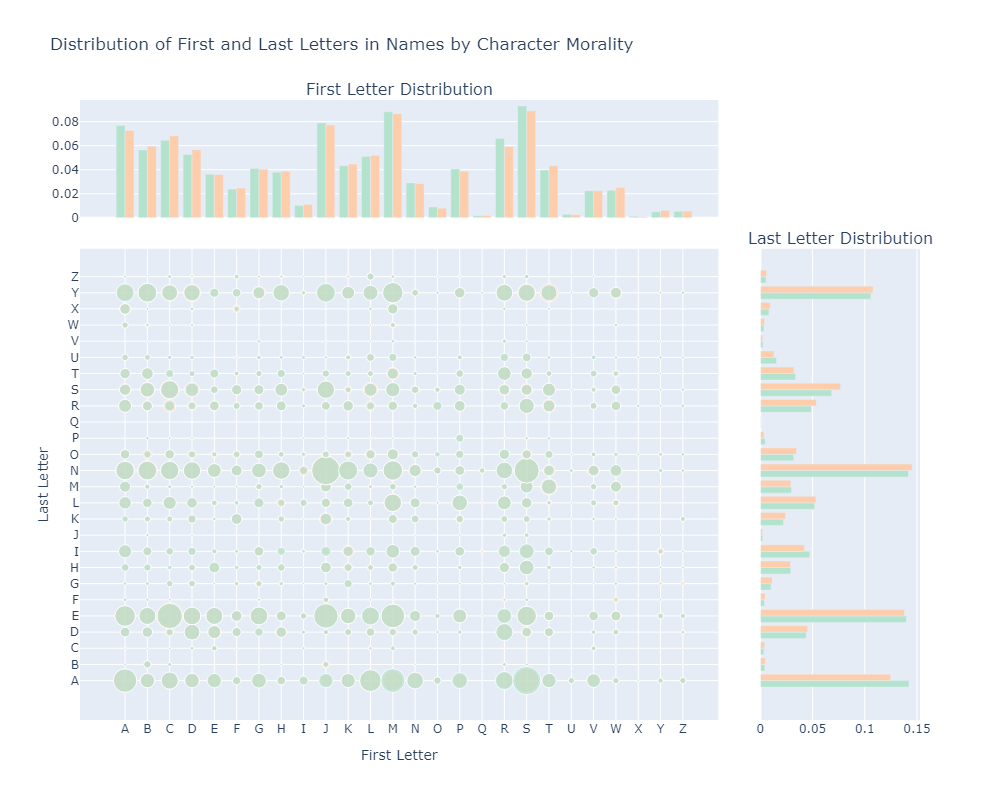

In [81]:
temp = character_names_processed_sa.copy()

# Extract first and last letters
temp['First_Letter'] = character_names_processed['Character_name'].str[0].str.upper()
temp['Last_Letter'] = character_names_processed['Character_name'].str[-1].str.upper()

temp = temp[temp['First_Letter'].str.match(r'^[A-Z]$')]
temp = temp[temp['Last_Letter'].str.match(r'^[A-Z]$')]

morality_letters = (
    temp
    .groupby(['First_Letter', 'Last_Letter', 'Interpretation_SA'])
    .size()
    .reset_index(name='Count')
)

# Calculate total count and distribution
total_count_by_morality = morality_letters.groupby('Interpretation_SA')['Count'].sum().reset_index()
total_count_by_morality = total_count_by_morality.rename(columns={'Count': 'Total'})
morality_letters = morality_letters.merge(total_count_by_morality, on='Interpretation_SA')
morality_letters['Distribution'] = morality_letters['Count'] / morality_letters['Total']

# Filter neutral
filtered_morality_letters = morality_letters[morality_letters['Interpretation_SA'].isin(['Nice guy', 'Bad guy'])]

filtered_morality_letters_first = (
    filtered_morality_letters
    .groupby(['First_Letter', 'Interpretation_SA'])['Distribution']
    .sum()
    .reset_index()
)

filtered_morality_letters_last = (
    filtered_morality_letters
    .groupby(['Last_Letter', 'Interpretation_SA'])['Distribution']
    .sum()
    .reset_index()
)

alphabet_order = list('ABCDEFGHIJKLMNOPQRSTUVWXYZ')

original_colors = {'Nice guy': '#B3E2CD', 'Bad guy': '#FDCDAC'}

fig = make_subplots(
    rows=2, cols=2,
    column_widths=[0.8, 0.2],
    row_heights=[0.2, 0.8],
    shared_xaxes=True,
    shared_yaxes=True,
    vertical_spacing=0.05,
    horizontal_spacing=0.05,
    subplot_titles=("First Letter Distribution", "", "", "Last Letter Distribution")
)

fig.add_trace(
    go.Scatter(
        x=filtered_morality_letters['First_Letter'],
        y=filtered_morality_letters['Last_Letter'],
        mode='markers',
        marker=dict(
            size=filtered_morality_letters['Distribution'] * 20000,  
            color=filtered_morality_letters['Interpretation_SA'].map(original_colors),
            opacity=0.7,
            line=dict(width=1, color="white"),
            sizemode='area',
        ),
        customdata=filtered_morality_letters[['Distribution', 'Interpretation_SA']],
        hovertemplate=(
            "First Letter: %{x}<br>"
            "Last Letter: %{y}<br>"
            "Distribution: %{customdata[0]:.2f}<br>"
            "Character Morality: %{customdata[1]}"
        ),
        name=""
    ),
    row=2, col=1
)

for morality, color in original_colors.items():
    filtered_first = filtered_morality_letters_first[filtered_morality_letters_first['Interpretation_SA'] == morality]
    fig.add_trace(
        go.Bar(
            x=filtered_first['First_Letter'],
            y=filtered_first['Distribution'],
            marker_color=color,
            name=f"{morality} First Letter",
        ),
        row=1, col=1
    )

for morality, color in original_colors.items():
    filtered_last = filtered_morality_letters_last[filtered_morality_letters_last['Interpretation_SA'] == morality]
    fig.add_trace(
        go.Bar(
            x=filtered_last['Distribution'],
            y=filtered_last['Last_Letter'],
            marker_color=color,
            name=f"{morality} Last Letter",
            orientation='h',
        ),
        row=2, col=2
    )

fig.update_layout(
    title_text="Distribution of First and Last Letters in Names by Character Morality",
    height=800,
    width=1000,
    showlegend=False,
    legend=dict(
        title="Character Morality",
        orientation="h",
        x=0.5,
        xanchor="center",
        y=-0.2
    ),
    barmode="group"
)

fig.update_xaxes(title_text="First Letter", row=2, col=1, categoryorder='array', categoryarray=alphabet_order)
fig.update_yaxes(title_text="Last Letter", row=2, col=1, categoryorder='array', categoryarray=alphabet_order)

fig_path = 'images/plot_27.png'
# fig.write_image(fig_path)
Image(fig_path)

In [82]:
alphabet_order = list('ABCDEFGHIJKLMNOPQRSTUVWXYZ')
alphabet_order_lower = [letter.lower() for letter in alphabet_order]

significant_results = []

for letter in alphabet_order_lower:

    contingency_table = pd.crosstab(character_names_processed_sa[f'{letter}_f'], character_names_processed_sa['Interpretation_SA'])
    chi2, p, dof, expected = chi2_contingency(contingency_table)
    
    # Chi-2 test
    chi2, p, dof, expected = chi2_contingency(contingency_table)  
    
    # Calculate Cramér's V
    n = contingency_table.sum().sum()
    k = min(contingency_table.shape)
    cramers_v = np.sqrt(chi2 / (n * (k - 1)))
    
    # Significant results
    if p < 0.05 and cramers_v > 0.01:
        significant_results.append((letter, p, cramers_v))

print("Names' First Letters with p < 0.05 and Cramér's V > 0.1:")
for letter, p, cramers_v in significant_results:
    print(f"First Letter: {letter}, p-value: {p:.4f}, Cramér's V: {cramers_v:.3f}")

first_significant = sorted(significant_results, key=lambda x: x[2], reverse=True)

Names' First Letters with p < 0.05 and Cramér's V > 0.1:
First Letter: j, p-value: 0.0216, Cramér's V: 0.011
First Letter: r, p-value: 0.0078, Cramér's V: 0.013


In [83]:
alphabet_order = list('ABCDEFGHIJKLMNOPQRSTUVWXYZ')
alphabet_order_lower = [letter.lower() for letter in alphabet_order]

significant_results = []

for letter in alphabet_order_lower:

    contingency_table = pd.crosstab(character_names_processed_sa[f'{letter}_l'], character_names_processed_sa['Interpretation_SA'])
    chi2, p, dof, expected = chi2_contingency(contingency_table)
    
    # Chi-2 test
    chi2, p, dof, expected = chi2_contingency(contingency_table)  
    
    # Calculate Cramér's V
    n = contingency_table.sum().sum()
    k = min(contingency_table.shape)
    cramers_v = np.sqrt(chi2 / (n * (k - 1)))
    
    # Significant results
    if p < 0.05 and cramers_v > 0.01:
        significant_results.append((letter, p, cramers_v))

print("Names' Last Letters with p < 0.05 and Cramér's V > 0.1:")
for letter, p, cramers_v in significant_results:
    print(f"Last Letter: {letter}, p-value: {p:.4f}, Cramér's V: {cramers_v:.3f}")

first_significant = sorted(significant_results, key=lambda x: x[2], reverse=True)

Names' Last Letters with p < 0.05 and Cramér's V > 0.1:
Last Letter: a, p-value: 0.0000, Cramér's V: 0.024
Last Letter: i, p-value: 0.0032, Cramér's V: 0.014
Last Letter: p, p-value: 0.0433, Cramér's V: 0.010
Last Letter: r, p-value: 0.0315, Cramér's V: 0.011
Last Letter: s, p-value: 0.0000, Cramér's V: 0.020
Last Letter: y, p-value: 0.0157, Cramér's V: 0.012


### 4.2.c. Name Diacritics / Character Type

In [84]:
# Diacritic characters
diacritics_set = set("üéèäöÃëçÖïáéäÔþçÁøõãæšáàÂùðìôêÖØÀûßýÉïåÓúśíłÅÞūžâÍÈëōîñüèóöÕò")

significant_results = []

for letter in diacritics_set:
    if f'{letter}' in ethnicity_processed.columns:  
        contingency_table = pd.crosstab(character_names_processed_sa[f'{letter}'], character_names_processed_sa['Interpretation_SA'])
        chi2, p, dof, expected = chi2_contingency(contingency_table)

        # Chi-2
        chi2, p, dof, expected = chi2_contingency(contingency_table)  

        significant_results.append((letter, p, cramers_v))

# Display significant results
print("Names' First Letters with p < 0.05 and Cramér's V > 0.1:")
for letter, p, cramers_v in significant_results:
    print(f"First Letter: {letter}, p-value: {p:.4f}, Cramér's V: {cramers_v:.3f}")

significant = sorted(significant_results, key=lambda x: x[2], reverse=True)

Names' First Letters with p < 0.05 and Cramér's V > 0.1:
First Letter: á, p-value: 1.0000, Cramér's V: 0.012
First Letter: ã, p-value: 1.0000, Cramér's V: 0.012
First Letter: ä, p-value: 1.0000, Cramér's V: 0.012
First Letter: é, p-value: 1.0000, Cramér's V: 0.012
First Letter: ï, p-value: 1.0000, Cramér's V: 0.012
First Letter: è, p-value: 1.0000, Cramér's V: 0.012
First Letter: ö, p-value: 1.0000, Cramér's V: 0.012
First Letter: ü, p-value: 1.0000, Cramér's V: 0.012
First Letter: ë, p-value: 1.0000, Cramér's V: 0.012
First Letter: ç, p-value: 1.0000, Cramér's V: 0.012


# 5. Focus on Characteristics of Bad guys in American and Russian movies

In [85]:
df_origin = pd.read_csv('data/movie_character_ethnicity.csv')
df_origin.drop(columns='Unnamed: 0', inplace=True)

df_char_cleaned_SA = character_names_processed_sa.copy()

colonnes_a_conserver = [
    'Wikipedia_ID', 'Name', 'Languages', 'Country', 
    'Character_name', 'Sex', 'Actor_age', 'Release_date', 
    'Genre_Category', 'Polarity', 'Interpretation_SA'
]

df_char_cleaned_SA = df_char_cleaned_SA[colonnes_a_conserver].copy()

# Merging SA dataset and Origin dataset and movie dataset
df_ethn_SA = pd.merge(df_char_cleaned_SA, df_origin, left_on='Character_name', right_on='Name', how='inner')

df_ethn_SA['Country'] = df_ethn_SA['Country'].str[0]

df_ethn_SA = df_ethn_SA.drop(columns=['Wikipedia_ID','Name_x','Languages','Actor_age','Name_y'])
df_ethn_SA.rename(columns={'Ethnicity': 'Origin'})
df_ethn_SA = df_ethn_SA.drop_duplicates()

## 5.1. Are Bad guys in American Movies Slavic and vice-versa ?

In [86]:
#Filtering dataframe to only movies from Russia and USA
df_usa = df_ethn_SA[df_ethn_SA['Country']=='United States of America']
df_rus = df_ethn_SA[df_ethn_SA['Country']=='Russia']

In [87]:
df_usa['Count']=1
df_usa1 = df_usa.groupby(['Interpretation_SA', 'Ethnicity'])['Count'].sum().reset_index()

# Drop rows with specific ethnicities in a single step
df_usa1.loc[:,'Proportion'] = df_usa1.groupby('Interpretation_SA')['Count'].transform(lambda x: x / x.sum())

#We only want the villains
df_usa1 = df_usa1.loc[df_usa1['Interpretation_SA']=='Bad guy'].copy()

df_usa1.head(10)

C:\Users\amaur\AppData\Local\Temp\ipykernel_7780\2446607030.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,Interpretation_SA,Ethnicity,Count,Proportion
0,Bad guy,East Asian,536,0.038877
1,Bad guy,English-Speaking,7190,0.521506
2,Bad guy,Hispanic,1100,0.079785
3,Bad guy,Romance,2465,0.178792
4,Bad guy,Slavic,2496,0.181040


In [88]:
df_rus['Count']=1
df_rus1 = df_rus.groupby(['Interpretation_SA', 'Ethnicity'])['Count'].sum().reset_index()

df_rus1.loc[:,'Proportion'] = df_rus1.groupby('Interpretation_SA')['Count'].transform(lambda x: x / x.sum())

#We only want the bad guys
df_rus1 = df_rus1.loc[df_rus1['Interpretation_SA']=='Bad guy'].copy()

#We sort to have same order as fro usa
df_rus1 = df_rus1.sort_values(by='Ethnicity',ascending=True)
df_rus1.head(10)

C:\Users\amaur\AppData\Local\Temp\ipykernel_7780\2767769396.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,Interpretation_SA,Ethnicity,Count,Proportion
0,Bad guy,East Asian,1,0.055556
1,Bad guy,English-Speaking,3,0.166667
2,Bad guy,Hispanic,2,0.111111
3,Bad guy,Romance,3,0.166667
4,Bad guy,Slavic,9,0.500000


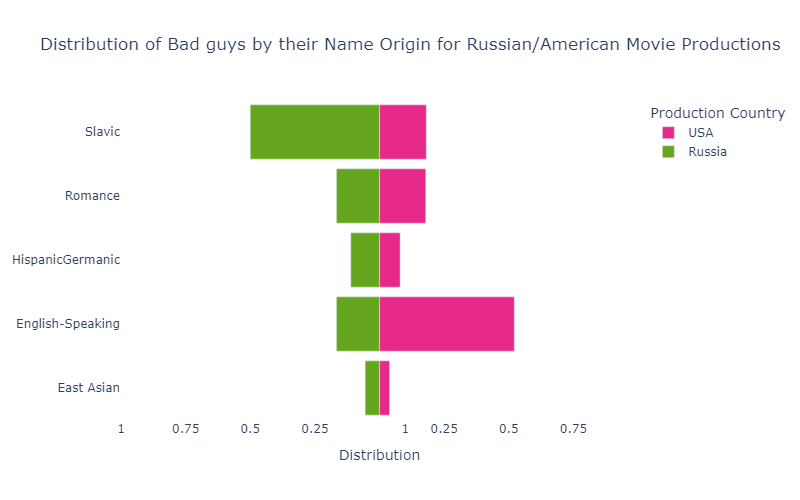

In [89]:
# define orgins in the right order
ethnicities = ['East Asian','English-Speaking','Hispanic' 'Germanic', 'Romance', 'Slavic']

fig = go.Figure()

fig.add_trace(go.Bar(
    x=df_usa1['Proportion'],
    y=ethnicities,
    orientation='h',
    name='USA',
    marker=dict(color='rgb(231,41,138)'),  
    offsetgroup=0
))

fig.add_trace(go.Bar(
    x=-df_rus1['Proportion'],
    y=ethnicities,
    orientation='h',
    name='Russia',
    marker=dict(color='rgb(102,166,30)'),  
    offsetgroup=0
))


fig.update_layout(
    title='Distribution of Bad guys by their Name Origin for Russian/American Movie Productions',
    xaxis=dict(
        title='Distribution',
        tickvals=[-1, -0.75, -0.50, -0.25, 0.25, 0.50, 0.75, 0.100],
        ticktext=['1', '0.75', '0.5', '0.25', '0.25', '0.5', '0.75', '1'], 
        range=[-1, 1]  
    ),
    barmode='relative',  
    bargap=0.15,
    plot_bgcolor='white',
    legend=dict(title='Production Country'),
    height=500,
    width=800
)

fig_path = 'images/plot_28.png'
# fig.write_image(fig_path)
Image(fig_path)

This plot tells us that in both countries villains are more likely to have english-speaking name ethnicities. Does that means that english-speaking names are usually chosen specifically for villain roles? Or just that they are the majority group and this results in a higher percentage in the graph? Let's dig deeper.

## 5.2 Morality Distribution across Name Origins

### 5.2.1 In American Movie Productions

In [90]:
def proportion_plot(df, title):   
    pivot_df = df.pivot_table(index='Ethnicity', columns='Interpretation_SA', values='Proportion')

    pivot_df = pivot_df.reset_index()

    long_df = pivot_df.reset_index().melt(id_vars='Ethnicity', value_vars=pivot_df.columns, 
                                        var_name='Interpretation_SA', value_name='Proportion')

    color_map = {
        'Nice guy': '#B3E2CD',  # Light green
        'Bad guy': '#FDCDAC',   # Light red
        'Neutral': '#CBD5E8'    # Light blue
    }

    fig = px.bar(long_df, 
                x='Proportion',
                y='Ethnicity', 
                color='Interpretation_SA', 
                orientation='h', 
                title=title,
                labels={
                    'Distribution': 'Proportion', 
                    'Ethnicity': 'Name Origin',
                    'Interpretation_SA': 'Character Morality'
                },
                barmode='stack', 
                hover_data=['Proportion'], 
                color_discrete_map=color_map
                )

    fig.update_layout(
        xaxis=dict(showgrid=False), 
        yaxis=dict(showgrid=False),
        plot_bgcolor='white',
        bargap=0.2
    )
    fig.show()

In [91]:
df_usa2 = df_usa.groupby(['Ethnicity','Interpretation_SA'])['Count'].sum().reset_index().copy()
df_usa2['Proportion'] = df_usa2.groupby('Ethnicity')['Count'].transform(lambda x: x / x.sum())
proportion_plot(df_usa2,"Proportion of Characters by Morality and Origin in American Movie Productions")
fig.write_html("plots/us-urss2.html")

As we see in this graph, English-Speaking ethnicities in character names are not that likely to play a villain role after all! Because they are the majority of the name in the USA, the result of the previous graph was misleading. We can notice that all ethnicity group have more or less the same proportion except from the nordic ethnicity group that tend to have more neutral roles in american movies.

### 5.2.2 In Russian Movie Productions

In [92]:
df_rus2 = df_rus.groupby(['Ethnicity','Interpretation_SA'])['Count'].sum().reset_index().copy()

df_rus2['Proportion'] = df_rus2.groupby('Ethnicity')['Count'].transform(lambda x: x / x.sum())

proportion_plot(df_rus2,"Proportion of Characters by Morality and Origin in Russian Movie Productions")
fig.write_html("plots/us-urss3.html")

## 5.3 And what about Movies during the Cold War

In [93]:
def get_year(date):
    str_year = str(date)[:4]
    year = int(str_year)
    return year


In [94]:
df_ethn_SA_cold_war = df_ethn_SA.copy()
df_ethn_SA_cold_war = df_ethn_SA_cold_war.fillna(value=0)
df_ethn_SA_cold_war['Year'] = df_ethn_SA_cold_war['Release_date'].apply(get_year)

In [95]:
# Filter american and russian movies
df_usa_cold_war = df_ethn_SA_cold_war[df_ethn_SA_cold_war['Country']=='United States of America']
df_rus_cold_war = df_ethn_SA_cold_war[df_ethn_SA_cold_war['Country']=='Russia']

# We filter movies to get only the noe released during the cold war

df_usa_cold_war = df_usa_cold_war.loc[(df_usa_cold_war['Year']>1947) & (df_usa_cold_war['Year']<1991)]
df_rus_cold_war = df_rus_cold_war.loc[(df_rus_cold_war['Year']>1947) & (df_rus_cold_war['Year']<1991)]
df_rus_cold_war.shape

(1, 9)

We only have 1 Russian Movie released during the Cold War :´( Therefore we will only analyze American Movie Productions.

In [96]:
df_usa_cold_war['Count']=1
df_usa_cold_plot = df_usa_cold_war.groupby(['Ethnicity','Interpretation_SA'])['Count'].sum().reset_index().copy()

df_usa_cold_plot['Proportion'] = df_usa_cold_plot.groupby('Ethnicity')['Count'].transform(lambda x: x / x.sum())

In [97]:
proportion_plot(df_usa_cold_plot, "Proportion of Characters by Morality and Origin in American Movie Productions during the Cold War")

We don't see a huge different with the precedent plot. The only difference is for Nordic ethnicity but it is due to an unsufficient number of datapoints for this class. Our theory that 'villains' in american movies released during the cold war tend to have slavic names is not confirmed. One hypothesis to explain this lack of evidences is that the dataset on movies was compiled by Americans, which may introduce a Western-centric bias. This bias could mean that even the Russian movies included in the dataset are those that are more Westernized, potentially leading to an overrepresentation of English-speaking ethnicities as the dominant group, even in Russian films. Additionally, this bias is evident in the underrepresentation of Russian movies, among others, in the dataset, as reflected in the disproportionate number of films produced per country.
We will now look at the evolution of villains ethnicity through the years to see if we can get some interesting insights.

## 5.4 Evolution of Bad guys Name Origin

In [98]:
df_ethn_SA_cold_war['Count']=1
df_usa_year = df_ethn_SA_cold_war[df_ethn_SA_cold_war['Country']=='United States of America'].copy()

#We regroup years into spans of 5 years to be sure to have enough data in each category
df_usa_year['Year_Category'] = (df_usa_year['Year'] // 5) * 5

#We remove movies before 1930 because we don't have enough data
df_usa_year = df_usa_year.loc[df_usa_year['Year_Category']>=1930].copy()

df_usa_year = df_usa_year.groupby(['Year_Category', 'Ethnicity'])['Count'].sum().reset_index()

In [99]:
pivot_df_year = df_usa_year.pivot_table(index='Year_Category', columns='Ethnicity', values='Count')
pivot_df_year=pivot_df_year.fillna(value=0).reset_index()

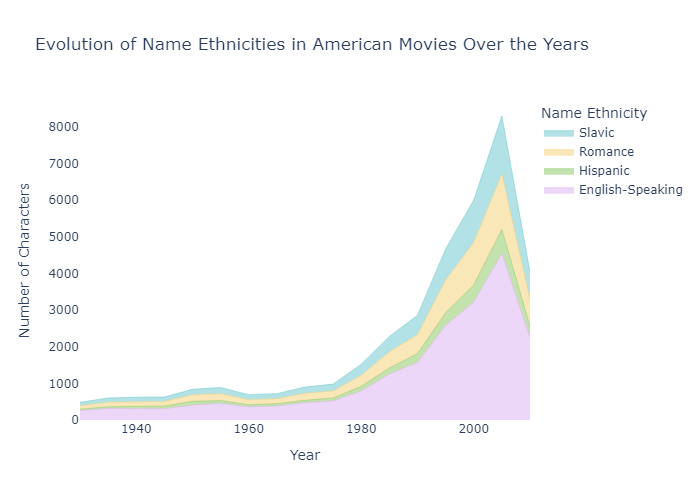

In [103]:
origins_order = ['Slavic', 'Romance', 'East Asian','English-Speaking', 'Hispanic']
pastel_colors = pc.Pastel
color_map = {origin: pastel_colors[i % len(pastel_colors)] for i, origin in enumerate(origins_order)}

fig = go.Figure()

for i, column in enumerate(pivot_df_year.columns[2:]):
    fig.add_trace(go.Scatter(
        x=pivot_df_year['Year_Category'], 
        y=pivot_df_year[column],
        stackgroup='one', 
        name=column,
        line=dict(width=0.5),
        marker=dict(color=color_map.get(column, '#D3D3D3'))
    ))

fig.update_layout(
    title='Evolution of Name Ethnicities in American Movies Over the Years',
    xaxis_title='Year',
    yaxis_title='Number of Characters',
    legend_title='Name Ethnicity',
    template='plotly',
    hovermode='x unified',
    showlegend=True,
    plot_bgcolor='white'
)

fig_path = 'images/plot_29.png'
# fig.write_image(fig_path)
Image(fig_path)

This plot shows a global increase in the number of characters over time. This rise can be attributed to two factors: firstly, an increase in the number of movies produced in the USA, and secondly, the underrepresentation of older movies in the dataset. A noticeable dip in the total number of characters occurs in 2010, which reflects a gap in the collection of movies from that period. What stands out is the growth of non-English origins over time. This trend suggests that from the 1980s onward, there was a movement towards greater diversity in character names within the American film industry. In particular, the prevalence of Romance and Slavic-origin names surged, and by 2005, nearly half of the characters' origins were non-English.